# CERN Electron Collision Data Analysis
## Resonance Peak Detection with Bayesian Uncertainty Quantification

## Project Overview

This project implements advanced machine learning techniques for resonance peak detection in electron-positron collision data from CERN, with a focus on uncertainty quantification - a critical requirement in experimental particle physics.

**Key Objectives:**
1. Detect resonance peaks (Z boson, J/psi, Upsilon family) using unsupervised learning
2. Implement Bayesian uncertainty quantification
3. Compare multiple anomaly detection approaches
4. Validate against known physics

---

## Table of Contents

1. Setup and Data Loading
2. Exploratory Data Analysis
3. Feature Engineering
4. Anomaly Detection - Isolation Forest
5. Anomaly Detection - Autoencoder
6. Bayesian Uncertainty Quantification
7. Peak Detection and Resonance Analysis
8. Method Comparison
9. Results and Conclusions

In [2]:

!pip install numpy pandas matplotlib seaborn scikit-learn scipy
!pip install tensorflow keras
!pip install plotly

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("All libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

2026-01-02 05:58:41.302720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767333521.549553      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767333521.616422      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767333522.201527      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767333522.201590      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767333522.201593      55 computation_placer.cc:177] computation placer alr

All libraries imported successfully
TensorFlow version: 2.19.0
NumPy version: 2.0.2


In [4]:

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 18

print("Plot configuration complete")

Plot configuration complete


---

## Part 1: Data Loading and Exploration

In this section, we load the CERN dielectron collision dataset and perform initial exploratory analysis to understand the data structure and physical variables.

In [9]:

df = pd.read_csv('/kaggle/input/cern-electron-collision-data/dielectron.csv')

print("Dataset loaded successfully")
print("Shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

Dataset loaded successfully
Shape: (100000, 19)

Column names:
['Run', 'Event', 'E1', 'px1 ', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', 'Q1', 'E2', 'px2', 'py2', 'pz2', 'pt2', 'eta2', 'phi2', 'Q2', 'M']

First few rows:
      Run      Event        E1      px1         py1       pz1       pt1  \
0  147115  366639895  58.71410  -7.31132  10.531000 -57.29740  12.82020   
1  147115  366704169   6.61188  -4.15213  -0.579855  -5.11278   4.19242   
2  147115  367112316  25.54190 -11.48090   2.041680  22.72460  11.66100   
3  147115  366952149  65.39590   7.51214  11.887100  63.86620  14.06190   
4  147115  366523212  61.45040   2.95284 -14.622700 -59.61210  14.91790   

      eta1     phi1  Q1       E2        px2      py2      pz2       pt2  \
0 -2.20267  2.17766   1  11.2836  -1.032340 -1.88066 -11.0778   2.14537   
1 -1.02842 -3.00284  -1  17.1492 -11.713500  5.04474  11.4647  12.75360   
2  1.42048  2.96560   1  15.8203  -1.472800  2.25895 -15.5888   2.69667   
3  2.21838  1.00721   1  25.1273  

In [10]:

print("Dataset Information:")
print("=" * 60)
print(df.info())

print("\n" + "=" * 60)
print("Statistical Summary:")
print("=" * 60)
print(df.describe())

print("\n" + "=" * 60)
print("Data Types:")
print("=" * 60)
print(df.dtypes)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Run     100000 non-null  int64  
 1   Event   100000 non-null  int64  
 2   E1      100000 non-null  float64
 3   px1     100000 non-null  float64
 4   py1     100000 non-null  float64
 5   pz1     100000 non-null  float64
 6   pt1     100000 non-null  float64
 7   eta1    100000 non-null  float64
 8   phi1    100000 non-null  float64
 9   Q1      100000 non-null  int64  
 10  E2      100000 non-null  float64
 11  px2     100000 non-null  float64
 12  py2     100000 non-null  float64
 13  pz2     100000 non-null  float64
 14  pt2     100000 non-null  float64
 15  eta2    100000 non-null  float64
 16  phi2    100000 non-null  float64
 17  Q2      100000 non-null  int64  
 18  M       99915 non-null   float64
dtypes: float64(15), int64(4)
memory usage: 14.5 MB
None

Statistical S

In [12]:

missing_values = df.isnull().sum()
print("Missing Values per Column:")
print("-" * 60)
for col in df.columns:
    missing = missing_values[col]
    if missing > 0:
        print(f"{col}: {missing} ({missing/len(df)*100:.2f}%)")

if missing_values.sum() == 0:
    print("No missing values found in the dataset")
else:
    print(f"\nTotal missing values: {missing_values.sum()}")
    # Handle missing values if any
    print("Dropping rows with missing values...")
    df = df.dropna()
    print(f"Cleaned dataset shape: {df.shape}")

Missing Values per Column:
------------------------------------------------------------
No missing values found in the dataset


In [13]:

print("Available columns in dataset:")
print("-" * 60)
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")

required_cols = ['E1', 'E2', 'px1', 'py1', 'pz1', 'px2', 'py2', 'pz2', 'M']
print("\n" + "=" * 60)
print("Checking for required columns:")
print("-" * 60)
for col in required_cols:
    if col in df.columns:
        print(f"[FOUND] {col}")
    else:
        print(f"[MISSING] {col}")

# Check if we have pt, eta, phi columns
optional_cols = ['pt1', 'pt2', 'eta1', 'eta2', 'phi1', 'phi2', 'Q1', 'Q2']
print("\n" + "=" * 60)
print("Checking for optional columns:")
print("-" * 60)
for col in optional_cols:
    if col in df.columns:
        print(f"[FOUND] {col}")
    else:
        print(f"[MISSING] {col}")

Available columns in dataset:
------------------------------------------------------------
1. Run
2. Event
3. E1
4. px1 
5. py1
6. pz1
7. pt1
8. eta1
9. phi1
10. Q1
11. E2
12. px2
13. py2
14. pz2
15. pt2
16. eta2
17. phi2
18. Q2
19. M

Checking for required columns:
------------------------------------------------------------
[FOUND] E1
[FOUND] E2
[MISSING] px1
[FOUND] py1
[FOUND] pz1
[FOUND] px2
[FOUND] py2
[FOUND] pz2
[FOUND] M

Checking for optional columns:
------------------------------------------------------------
[FOUND] pt1
[FOUND] pt2
[FOUND] eta1
[FOUND] eta2
[FOUND] phi1
[FOUND] phi2
[FOUND] Q1
[FOUND] Q2


In [16]:

print("Original dataset shape:", df.shape)
print(f"Missing values in M column: {df['M'].isnull().sum()}")


df = df.dropna(subset=['M'])

print(f"Dataset shape after cleaning: {df.shape}")
print(f"\nMass (M) statistics:")
print(f"  Min: {df['M'].min():.2f} GeV/c²")
print(f"  Max: {df['M'].max():.2f} GeV/c²")
print(f"  Mean: {df['M'].mean():.2f} GeV/c²")
print(f"  Median: {df['M'].median():.2f} GeV/c²")
print(f"  Std: {df['M'].std():.2f} GeV/c²")

Original dataset shape: (99915, 19)
Missing values in M column: 0
Dataset shape after cleaning: (99915, 19)

Mass (M) statistics:
  Min: 2.00 GeV/c²
  Max: 110.00 GeV/c²
  Mean: 30.02 GeV/c²
  Median: 21.28 GeV/c²
  Std: 25.26 GeV/c²


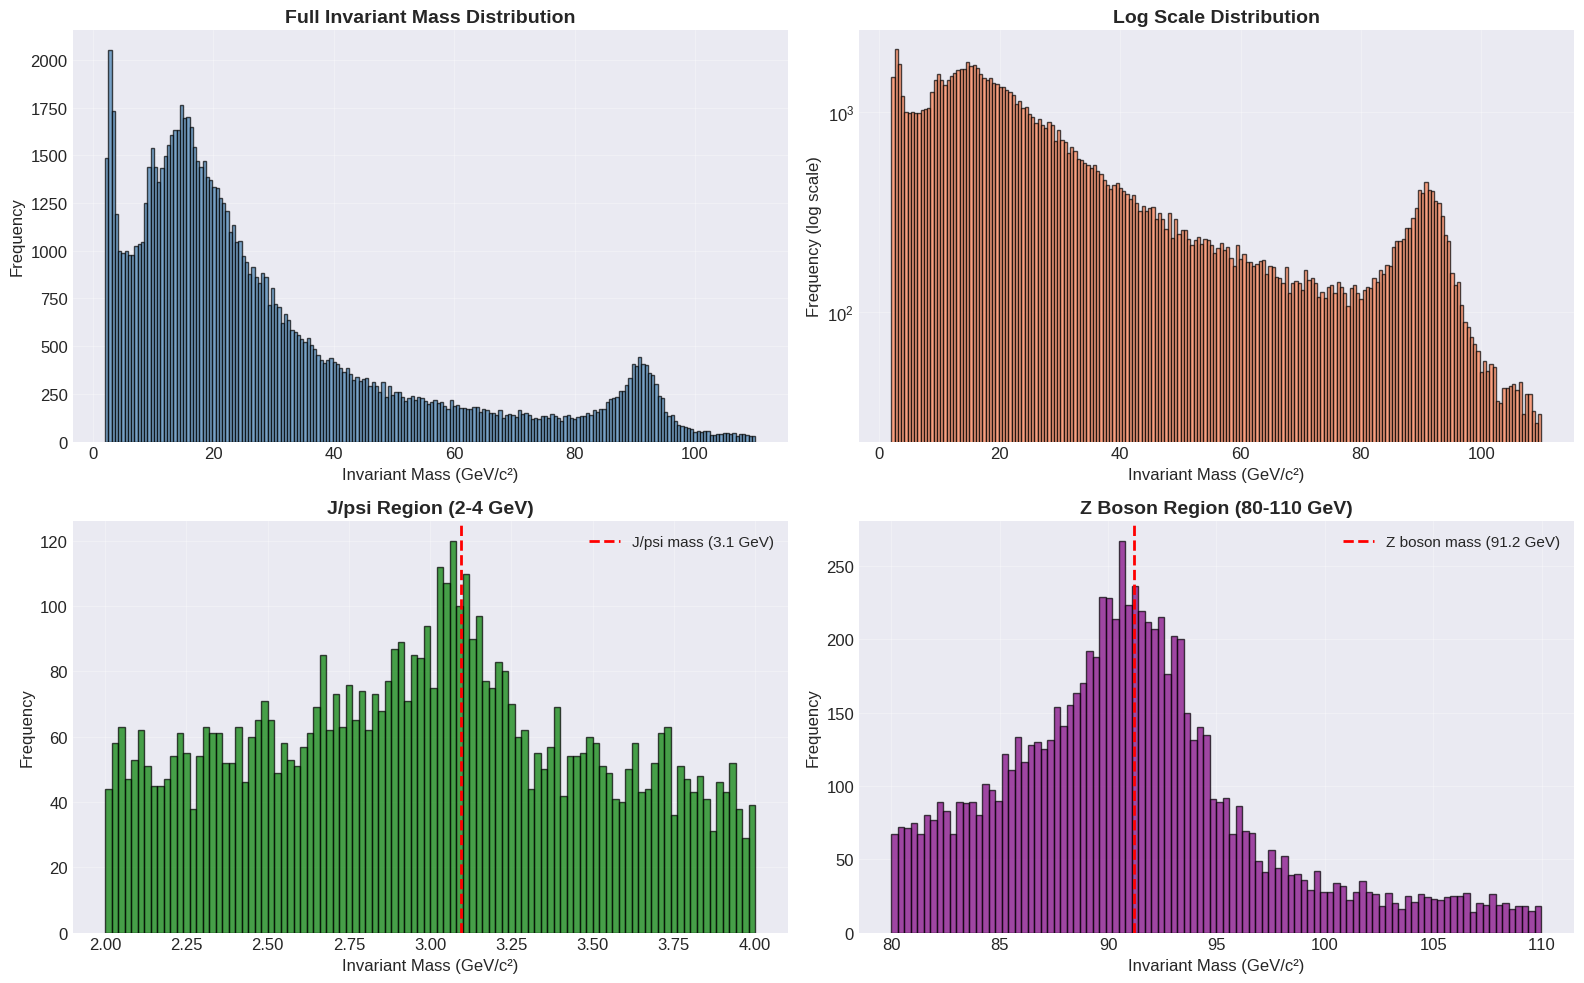

Total events: 99,915
Mass range: 2.00 - 110.00 GeV/c²
Events in J/psi region (2-4 GeV): 6,134
Events in Z region (80-110 GeV): 8,702


In [17]:

fig, axes = plt.subplots(2, 2, figsize=(16, 10))


axes[0, 0].hist(df['M'], bins=200, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Invariant Mass (GeV/c²)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Full Invariant Mass Distribution', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)


axes[0, 1].hist(df['M'], bins=200, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Invariant Mass (GeV/c²)', fontsize=12)
axes[0, 1].set_ylabel('Frequency (log scale)', fontsize=12)
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Log Scale Distribution', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)


jpsi_data = df[(df['M'] > 2) & (df['M'] < 4)]
axes[1, 0].hist(jpsi_data['M'], bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].axvline(3.096, color='red', linestyle='--', linewidth=2, label='J/psi mass (3.1 GeV)')
axes[1, 0].set_xlabel('Invariant Mass (GeV/c²)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('J/psi Region (2-4 GeV)', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)


z_data = df[(df['M'] > 80) & (df['M'] < 110)]
axes[1, 1].hist(z_data['M'], bins=100, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].axvline(91.2, color='red', linestyle='--', linewidth=2, label='Z boson mass (91.2 GeV)')
axes[1, 1].set_xlabel('Invariant Mass (GeV/c²)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Z Boson Region (80-110 GeV)', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('initial_mass_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Total events: {len(df):,}")
print(f"Mass range: {df['M'].min():.2f} - {df['M'].max():.2f} GeV/c²")
print(f"Events in J/psi region (2-4 GeV): {len(jpsi_data):,}")
print(f"Events in Z region (80-110 GeV): {len(z_data):,}")

---

## Part 2: Feature Engineering

We calculate additional kinematic variables that are commonly used in particle physics analysis. Since we already have pt, eta, and phi, we will calculate total energy, momentum, opening angles, and asymmetry measures.

In [21]:
df['E_total'] = df['E1'] + df['E2']
df['px_total'] = df['px1 '] + df['px2']
df['py_total'] = df['py1'] + df['py2']
df['pz_total'] = df['pz1'] + df['pz2']

df['pt_total'] = np.sqrt(df['px_total']**2 + df['py_total']**2)

df['p1'] = np.sqrt(df['px1 ']**2 + df['py1']**2 + df['pz1']**2)
df['p2'] = np.sqrt(df['px2']**2 + df['py2']**2 + df['pz2']**2)
df['p_total'] = np.sqrt(df['px_total']**2 + df['py_total']**2 + df['pz_total']**2)

df['cos_opening_angle'] = (df['px1 ']*df['px2'] + df['py1']*df['py2'] + df['pz1']*df['pz2']) / (df['p1'] * df['p2'])
df['opening_angle'] = np.arccos(np.clip(df['cos_opening_angle'], -1, 1))

df['delta_eta'] = df['eta1'] - df['eta2']
df['delta_phi'] = df['phi1'] - df['phi2']

df['delta_R'] = np.sqrt(df['delta_eta']**2 + df['delta_phi']**2)

epsilon = 1e-10
df['rapidity'] = 0.5 * np.log((df['E_total'] + df['pz_total'] + epsilon) / (df['E_total'] - df['pz_total'] + epsilon))

df['energy_asymmetry'] = (df['E1'] - df['E2']) / (df['E1'] + df['E2'])
df['pt_asymmetry'] = (df['pt1'] - df['pt2']) / (df['pt1'] + df['pt2'])

df['acoplanarity'] = 1 - np.abs(df['delta_phi']) / np.pi

print(df[['E_total', 'pt_total', 'p_total', 'opening_angle', 'delta_R', 'rapidity']].describe())

            E_total      pt_total       p_total  opening_angle       delta_R  \
count  99915.000000  99915.000000  99915.000000   99915.000000  99915.000000   
mean      80.488656     18.609348     69.998995       1.456194      3.061176   
std       57.368251     11.301241     57.711853       0.918160      1.402274   
min        3.314210      0.078824      0.489089       0.018792      0.101126   
25%       37.781650     11.971716     27.494392       0.594713      2.169473   
50%       70.198590     16.890196     56.194388       1.349272      3.203988   
75%      105.655875     22.837423     95.270984       2.311227      3.977918   
max      951.778680    278.523138    950.887218       3.139562      7.676088   

           rapidity  
count  99915.000000  
mean      -0.062776  
std        1.394574  
min       -3.647925  
25%       -1.253453  
50%       -0.074888  
75%        1.109658  
max        2.576048  


---

## Part 2: Feature Correlation Analysis

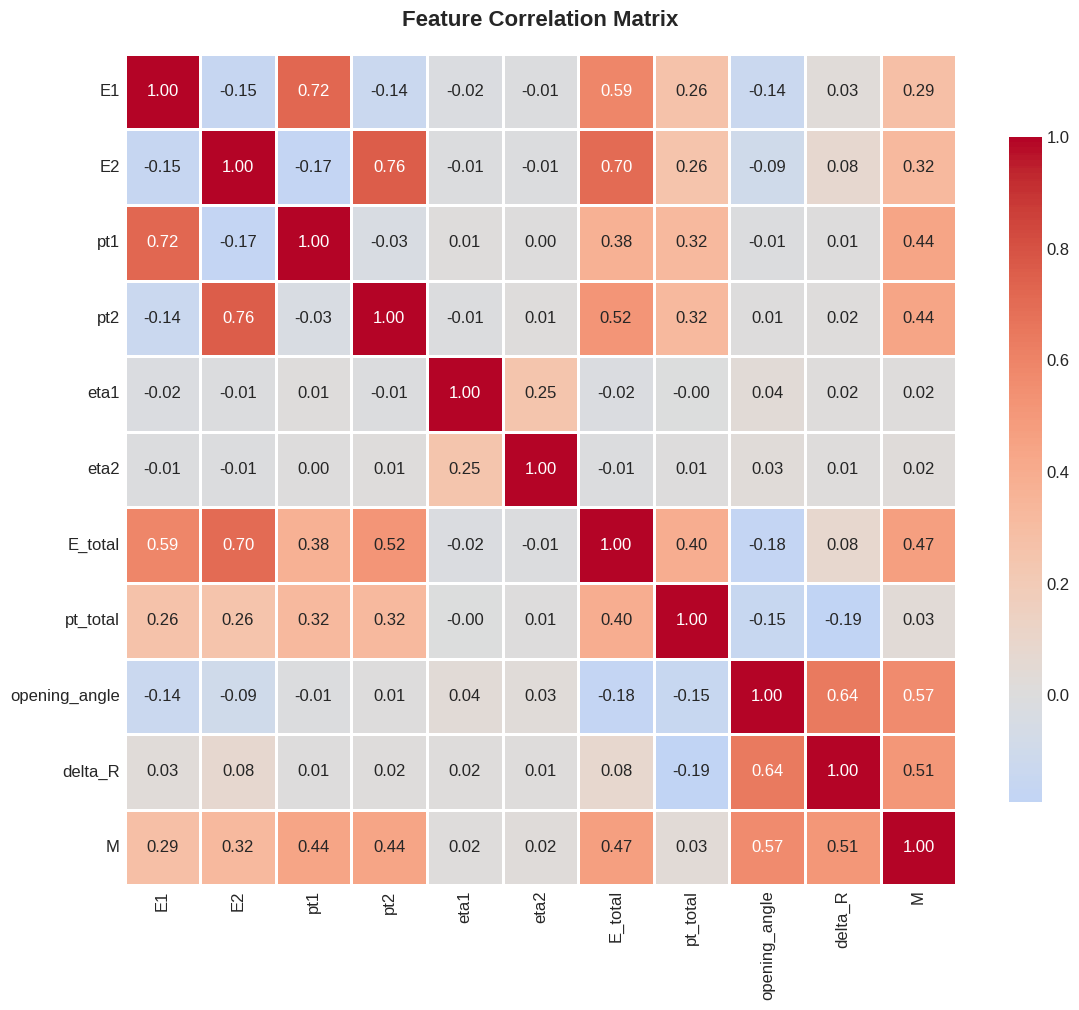

In [22]:
feature_cols = ['E1', 'E2', 'pt1', 'pt2', 'eta1', 'eta2', 
                'E_total', 'pt_total', 'opening_angle', 'delta_R', 'M']

correlation_matrix = df[feature_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

---

## Part 3: Anomaly Detection - Isolation Forest

In [23]:
anomaly_features = ['E1', 'E2', 'px1 ', 'py1', 'pz1', 'px2', 'py2', 'pz2',
                    'pt1', 'pt2', 'eta1', 'eta2', 'opening_angle', 
                    'E_total', 'pt_total', 'delta_R']

X_anomaly = df[anomaly_features].copy()

scaler = StandardScaler()
X_anomaly_scaled = scaler.fit_transform(X_anomaly)

print(f"Feature matrix shape: {X_anomaly_scaled.shape}")

Feature matrix shape: (99915, 16)


In [24]:
iso_forest = IsolationForest(
    contamination=0.1,
    random_state=RANDOM_SEED,
    n_estimators=100,
    max_samples='auto',
    n_jobs=-1
)

anomaly_scores_iso = iso_forest.fit_predict(X_anomaly_scaled)
anomaly_scores_iso_continuous = iso_forest.score_samples(X_anomaly_scaled)

df['iso_forest_label'] = anomaly_scores_iso
df['iso_forest_score'] = anomaly_scores_iso_continuous

n_anomalies_iso = (anomaly_scores_iso == -1).sum()
print(f"Detected anomalies: {n_anomalies_iso:,} ({n_anomalies_iso/len(df)*100:.2f}%)")

Detected anomalies: 9,992 (10.00%)


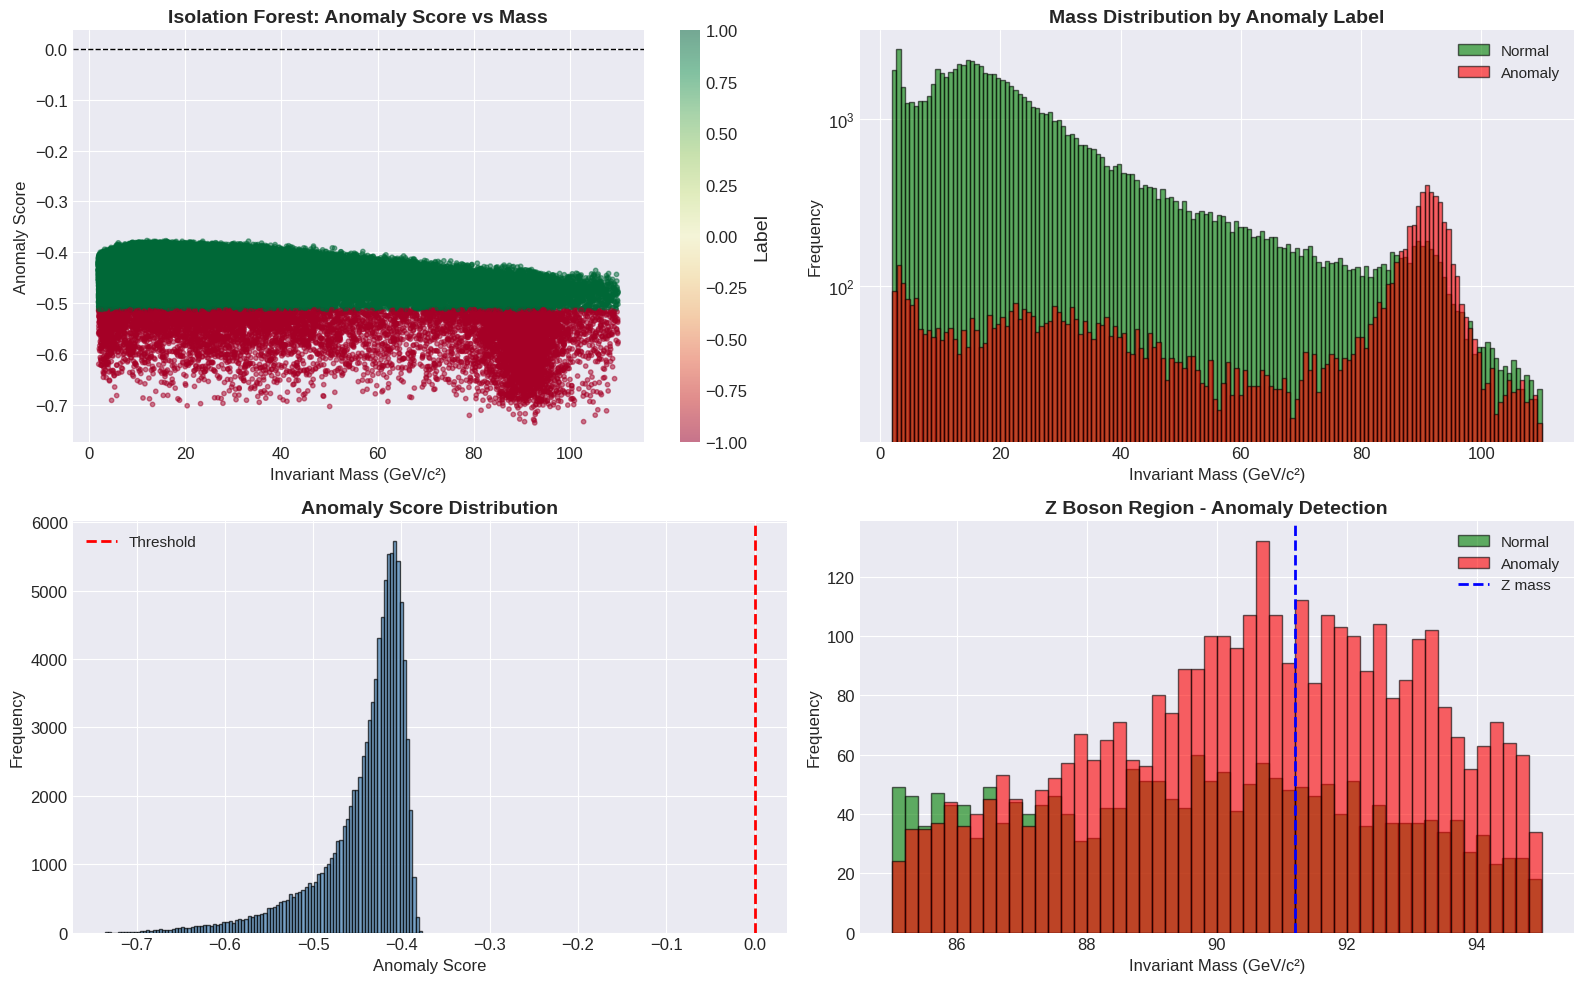

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

scatter = axes[0, 0].scatter(df['M'], df['iso_forest_score'], 
                             c=df['iso_forest_label'], cmap='RdYlGn',
                             alpha=0.5, s=10)
axes[0, 0].set_xlabel('Invariant Mass (GeV/c²)', fontsize=12)
axes[0, 0].set_ylabel('Anomaly Score', fontsize=12)
axes[0, 0].set_title('Isolation Forest: Anomaly Score vs Mass', fontsize=14, fontweight='bold')
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.colorbar(scatter, ax=axes[0, 0], label='Label')

axes[0, 1].hist(df[df['iso_forest_label'] == 1]['M'], bins=150, 
                alpha=0.6, label='Normal', color='green', edgecolor='black')
axes[0, 1].hist(df[df['iso_forest_label'] == -1]['M'], bins=150, 
                alpha=0.6, label='Anomaly', color='red', edgecolor='black')
axes[0, 1].set_xlabel('Invariant Mass (GeV/c²)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Mass Distribution by Anomaly Label', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].set_yscale('log')

axes[1, 0].hist(df['iso_forest_score'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 0].set_xlabel('Anomaly Score', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Anomaly Score Distribution', fontsize=14, fontweight='bold')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Threshold')
axes[1, 0].legend()

z_region = df[(df['M'] > 85) & (df['M'] < 95)]
axes[1, 1].hist(z_region[z_region['iso_forest_label'] == 1]['M'], bins=50, 
                alpha=0.6, label='Normal', color='green', edgecolor='black')
axes[1, 1].hist(z_region[z_region['iso_forest_label'] == -1]['M'], bins=50, 
                alpha=0.6, label='Anomaly', color='red', edgecolor='black')
axes[1, 1].axvline(91.2, color='blue', linestyle='--', linewidth=2, label='Z mass')
axes[1, 1].set_xlabel('Invariant Mass (GeV/c²)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Z Boson Region - Anomaly Detection', fontsize=14, fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('isolation_forest_results.png', dpi=300, bbox_inches='tight')
plt.show()

---

## Part 4: Anomaly Detection - Autoencoder

In [26]:
X_train, X_test = train_test_split(X_anomaly_scaled, test_size=0.2, random_state=RANDOM_SEED)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (79932, 16)
Test set: (19983, 16)


In [27]:
input_dim = X_train.shape[1]
encoding_dim = 8

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='relu')(input_layer)
encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(16, activation='relu')(encoded)
encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)

decoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.BatchNormalization()(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(32, activation='relu')(decoded)
decoded = layers.BatchNormalization()(decoded)
output_layer = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer, name='autoencoder')

autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

autoencoder.summary()

2026-01-02 06:03:34.632871: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,808 (10.97 KB)

 Trainable params: 2,616 (10.22 KB)

 Non-trainable params: 192 (768.00 B)

In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.2225 - mae: 0.8030 - val_loss: 0.5005 - val_mae: 0.5114 - learning_rate: 0.0010
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5611 - mae: 0.5400 - val_loss: 0.3439 - val_mae: 0.4177 - learning_rate: 0.0010
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4431 - mae: 0.4759 - val_loss: 0.2448 - val_mae: 0.3530 - learning_rate: 0.0010
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3619 - mae: 0.4263 - val_loss: 0.1851 - val_mae: 0.3041 - learning_rate: 0.0010
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3141 - mae: 0.3948 - val_loss: 0.1405 - val_mae: 0.2622 - learning_rate: 0.0010
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2760 - mae: 0.3689 - val_loss: 0.1102 - val_mae: 0.2295 - learning_rate: 0.0010
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2499 - mae: 0.3501 - val_loss: 0.0953 - val_mae: 0.2116 - learning_rate: 0.0010

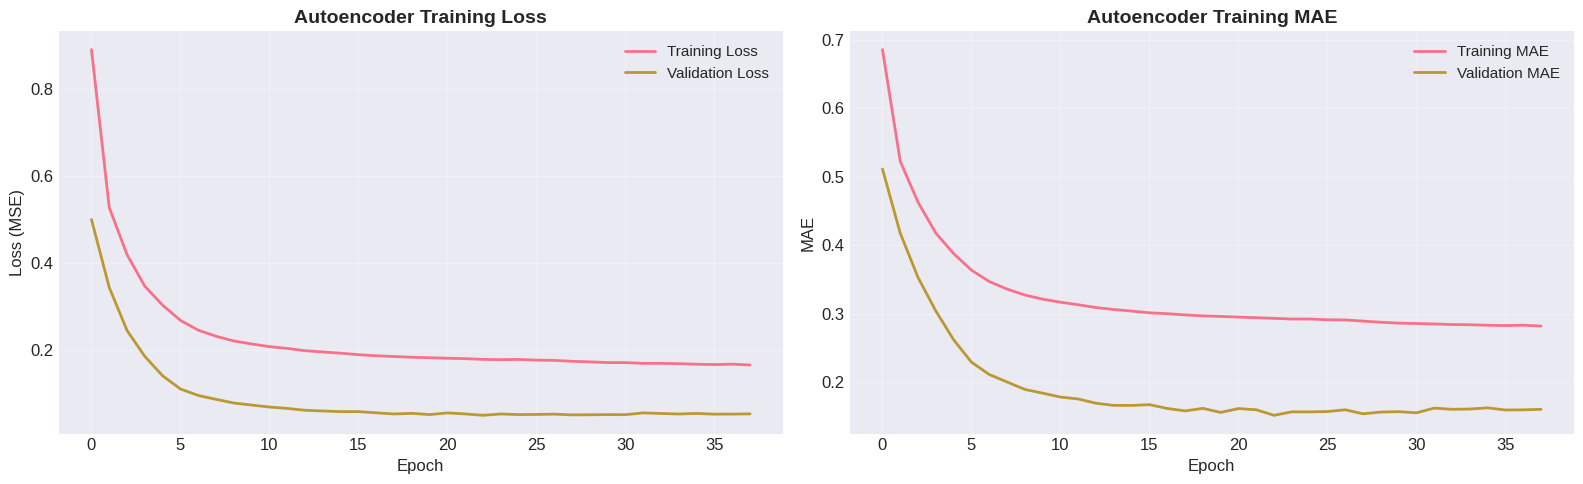

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Autoencoder Training Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Autoencoder Training MAE', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('autoencoder_training.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
X_pred = autoencoder.predict(X_anomaly_scaled, verbose=0)

reconstruction_error = np.mean(np.square(X_anomaly_scaled - X_pred), axis=1)

df['autoencoder_error'] = reconstruction_error

threshold = np.percentile(reconstruction_error, 95)
df['autoencoder_label'] = (reconstruction_error > threshold).astype(int)
df['autoencoder_label'] = df['autoencoder_label'].map({0: 1, 1: -1})

n_anomalies_ae = (df['autoencoder_label'] == -1).sum()

print(f"Anomaly threshold (95th percentile): {threshold:.6f}")
print(f"Detected anomalies: {n_anomalies_ae:,} ({n_anomalies_ae/len(df)*100:.2f}%)")
print(f"Mean reconstruction error: {reconstruction_error.mean():.6f}")
print(f"Std reconstruction error: {reconstruction_error.std():.6f}")

Anomaly threshold (95th percentile): 0.139227
Detected anomalies: 4,996 (5.00%)
Mean reconstruction error: 0.048946
Std reconstruction error: 0.114989


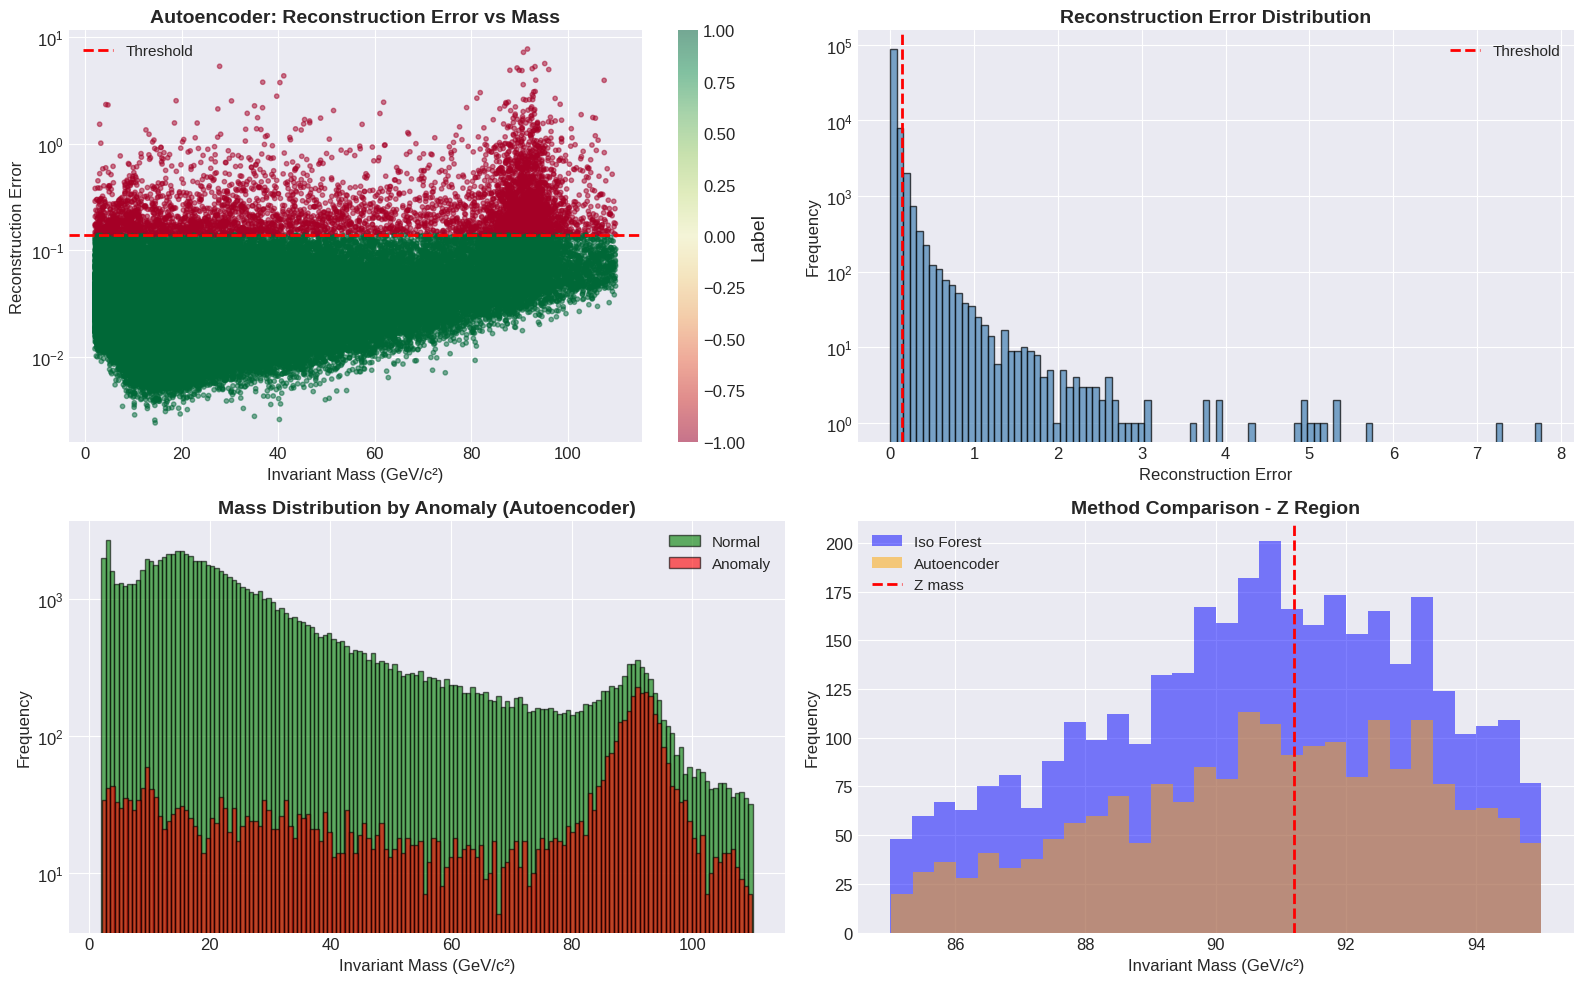

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

scatter = axes[0, 0].scatter(df['M'], df['autoencoder_error'], 
                             c=df['autoencoder_label'], cmap='RdYlGn',
                             alpha=0.5, s=10)
axes[0, 0].axhline(y=threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
axes[0, 0].set_xlabel('Invariant Mass (GeV/c²)', fontsize=12)
axes[0, 0].set_ylabel('Reconstruction Error', fontsize=12)
axes[0, 0].set_title('Autoencoder: Reconstruction Error vs Mass', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].set_yscale('log')
plt.colorbar(scatter, ax=axes[0, 0], label='Label')

axes[0, 1].hist(reconstruction_error, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
axes[0, 1].set_xlabel('Reconstruction Error', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Reconstruction Error Distribution', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].set_yscale('log')

axes[1, 0].hist(df[df['autoencoder_label'] == 1]['M'], bins=150, 
                alpha=0.6, label='Normal', color='green', edgecolor='black')
axes[1, 0].hist(df[df['autoencoder_label'] == -1]['M'], bins=150, 
                alpha=0.6, label='Anomaly', color='red', edgecolor='black')
axes[1, 0].set_xlabel('Invariant Mass (GeV/c²)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Mass Distribution by Anomaly (Autoencoder)', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].set_yscale('log')

z_region = df[(df['M'] > 85) & (df['M'] < 95)]
iso_anom = z_region[z_region['iso_forest_label'] == -1]
ae_anom = z_region[z_region['autoencoder_label'] == -1]

axes[1, 1].hist(iso_anom['M'], bins=30, alpha=0.5, label='Iso Forest', color='blue')
axes[1, 1].hist(ae_anom['M'], bins=30, alpha=0.5, label='Autoencoder', color='orange')
axes[1, 1].axvline(91.2, color='red', linestyle='--', linewidth=2, label='Z mass')
axes[1, 1].set_xlabel('Invariant Mass (GeV/c²)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Method Comparison - Z Region', fontsize=14, fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('autoencoder_results.png', dpi=300, bbox_inches='tight')
plt.show()

---

## Part 5: Bayesian Uncertainty Quantification

In [34]:
z_region_data = df[(df['M'] > 70) & (df['M'] < 110)].copy()

feature_cols_bayesian = ['E1', 'E2', 'pt1', 'pt2', 'eta1', 'eta2', 
                         'opening_angle', 'pt_total']
X_bayes = z_region_data[feature_cols_bayesian].values
y_bayes = z_region_data['M'].values

scaler_bayes = StandardScaler()
X_bayes_scaled = scaler_bayes.fit_transform(X_bayes)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_bayes_scaled, y_bayes, test_size=0.2, random_state=RANDOM_SEED
)

print(f"Training samples: {len(X_train_b):,}")
print(f"Test samples: {len(X_test_b):,}")
print(f"Features: {X_train_b.shape[1]}")

Training samples: 8,914
Test samples: 2,229
Features: 8


In [35]:
def build_bayesian_model(input_dim, dropout_rate=0.2):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(32, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(16, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

bayesian_model = build_bayesian_model(X_train_b.shape[1], dropout_rate=0.3)

bayesian_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
early_stop_bayes = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr_bayes = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)

history_bayes = bayesian_model.fit(
    X_train_b, y_train_b,
    epochs=150,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop_bayes, reduce_lr_bayes],
    verbose=1
)

Epoch 1/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7245.9727 - mae: 84.4652 - val_loss: 2446.5894 - val_mae: 47.1111 - learning_rate: 0.0010
Epoch 2/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1853.1780 - mae: 35.9229 - val_loss: 286.2806 - val_mae: 13.8611 - learning_rate: 0.0010
Epoch 3/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1150.4581 - mae: 27.4094 - val_loss: 278.6784 - val_mae: 13.4960 - learning_rate: 0.0010
Epoch 4/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 978.4409 - mae: 25.2843 - val_loss: 226.7439 - val_mae: 12.1589 - learning_rate: 0.0010
Epoch 5/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 875.3477 - mae: 23.9947 - val_loss: 225.7402 - val_mae: 12.2299 - learning_rate: 0.0010
Epoch 6/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 856.7032 - mae: 23.6870 - val_loss: 237.6696 - val_mae: 12.7299 - learning_rate: 0.0010
Epoch 7/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 830.5306 - mae: 23.1781 - val_loss: 185.6045 - val_mae:

In [37]:
def mc_predictions(model, X, n_samples=100):
    predictions = []
    for _ in range(n_samples):
        preds = model(X, training=True)
        predictions.append(preds.numpy().flatten())
    return np.array(predictions)

n_mc_samples = 100
mc_preds_test = mc_predictions(bayesian_model, X_test_b, n_samples=n_mc_samples)

y_pred_mean = mc_preds_test.mean(axis=0)
y_pred_std = mc_preds_test.std(axis=0)

lower_bound = y_pred_mean - 1.96 * y_pred_std
upper_bound = y_pred_mean + 1.96 * y_pred_std

mse_bayes = mean_squared_error(y_test_b, y_pred_mean)
mae_bayes = mean_absolute_error(y_test_b, y_pred_mean)
r2_bayes = r2_score(y_test_b, y_pred_mean)

print(f"MSE: {mse_bayes:.4f}")
print(f"MAE: {mae_bayes:.4f}")
print(f"R² Score: {r2_bayes:.4f}")
print(f"Mean uncertainty: {y_pred_std.mean():.4f} GeV")

MSE: 87.3561
MAE: 7.1226
R² Score: -0.1978
Mean uncertainty: 24.0520 GeV


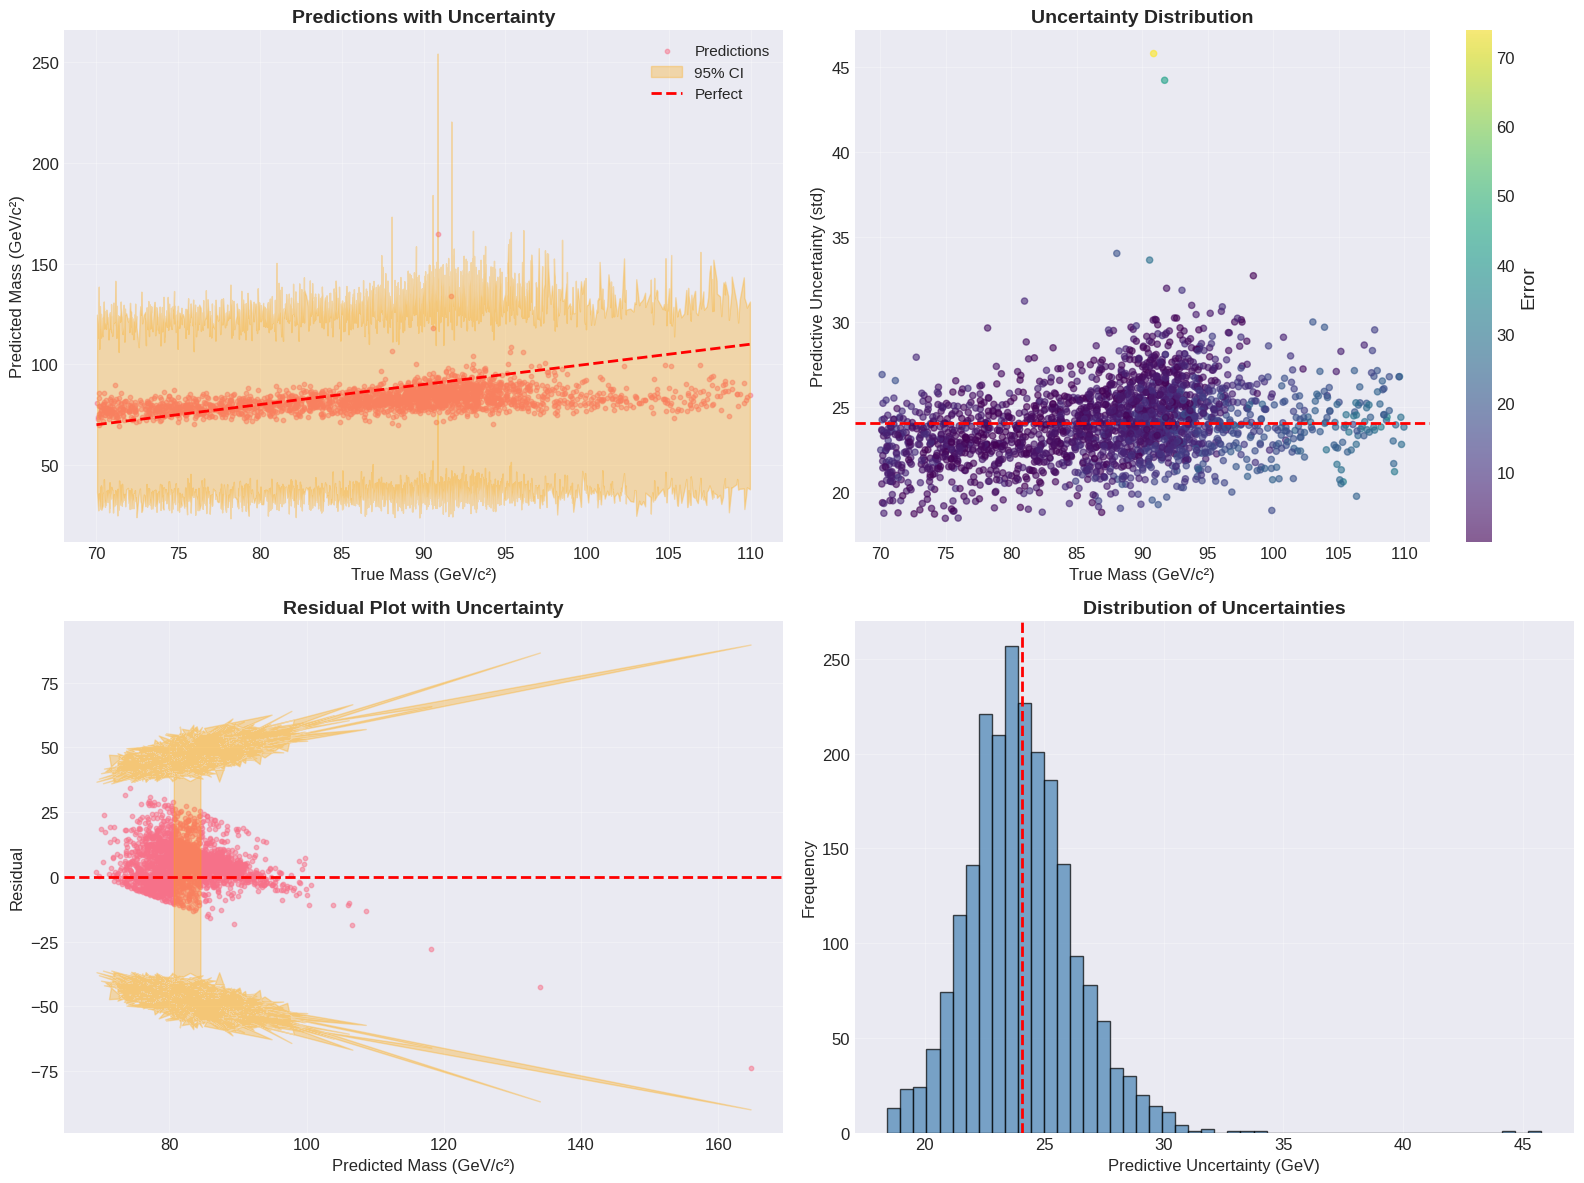

In [38]:
sort_idx = np.argsort(y_test_b)
y_test_sorted = y_test_b[sort_idx]
y_pred_sorted = y_pred_mean[sort_idx]
y_std_sorted = y_pred_std[sort_idx]
lower_sorted = lower_bound[sort_idx]
upper_sorted = upper_bound[sort_idx]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].scatter(y_test_sorted, y_pred_sorted, alpha=0.5, s=10, label='Predictions')
axes[0, 0].fill_between(y_test_sorted, lower_sorted, upper_sorted, 
                        alpha=0.3, color='orange', label='95% CI')
axes[0, 0].plot([70, 110], [70, 110], 'r--', linewidth=2, label='Perfect')
axes[0, 0].set_xlabel('True Mass (GeV/c²)', fontsize=12)
axes[0, 0].set_ylabel('Predicted Mass (GeV/c²)', fontsize=12)
axes[0, 0].set_title('Predictions with Uncertainty', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

scatter = axes[0, 1].scatter(y_test_b, y_pred_std, c=np.abs(y_test_b - y_pred_mean), 
                            cmap='viridis', alpha=0.6, s=20)
axes[0, 1].axhline(y_pred_std.mean(), color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('True Mass (GeV/c²)', fontsize=12)
axes[0, 1].set_ylabel('Predictive Uncertainty (std)', fontsize=12)
axes[0, 1].set_title('Uncertainty Distribution', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 1], label='Error')

residuals = y_test_b - y_pred_mean
axes[1, 0].scatter(y_pred_mean, residuals, alpha=0.5, s=10)
axes[1, 0].fill_between(y_pred_sorted, -1.96*y_std_sorted, 1.96*y_std_sorted, 
                       alpha=0.3, color='orange')
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Mass (GeV/c²)', fontsize=12)
axes[1, 0].set_ylabel('Residual', fontsize=12)
axes[1, 0].set_title('Residual Plot with Uncertainty', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(y_pred_std, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 1].axvline(y_pred_std.mean(), color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predictive Uncertainty (GeV)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Distribution of Uncertainties', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('uncertainty_quantification.png', dpi=300, bbox_inches='tight')
plt.show()

---

## Part 6: Peak Detection and Resonance Analysis

In [40]:
bin_edges = np.arange(df['M'].min(), df['M'].max(), 0.2)
hist, edges = np.histogram(df['M'], bins=bin_edges)
bin_centers = (edges[:-1] + edges[1:]) / 2

hist_smoothed = gaussian_filter1d(hist.astype(float), sigma=2)

peaks, properties = find_peaks(hist_smoothed, 
                               height=np.percentile(hist_smoothed, 75),
                               distance=10,
                               prominence=100)

print(f"Found {len(peaks)} potential resonance peaks")
for i, peak_idx in enumerate(peaks):
    mass = bin_centers[peak_idx]
    height = hist_smoothed[peak_idx]
    print(f"Peak {i+1}: Mass = {mass:.2f} GeV/c², Height = {height:.0f}")

Found 2 potential resonance peaks
Peak 1: Mass = 2.90 GeV/c², Height = 701
Peak 2: Mass = 14.70 GeV/c², Height = 635


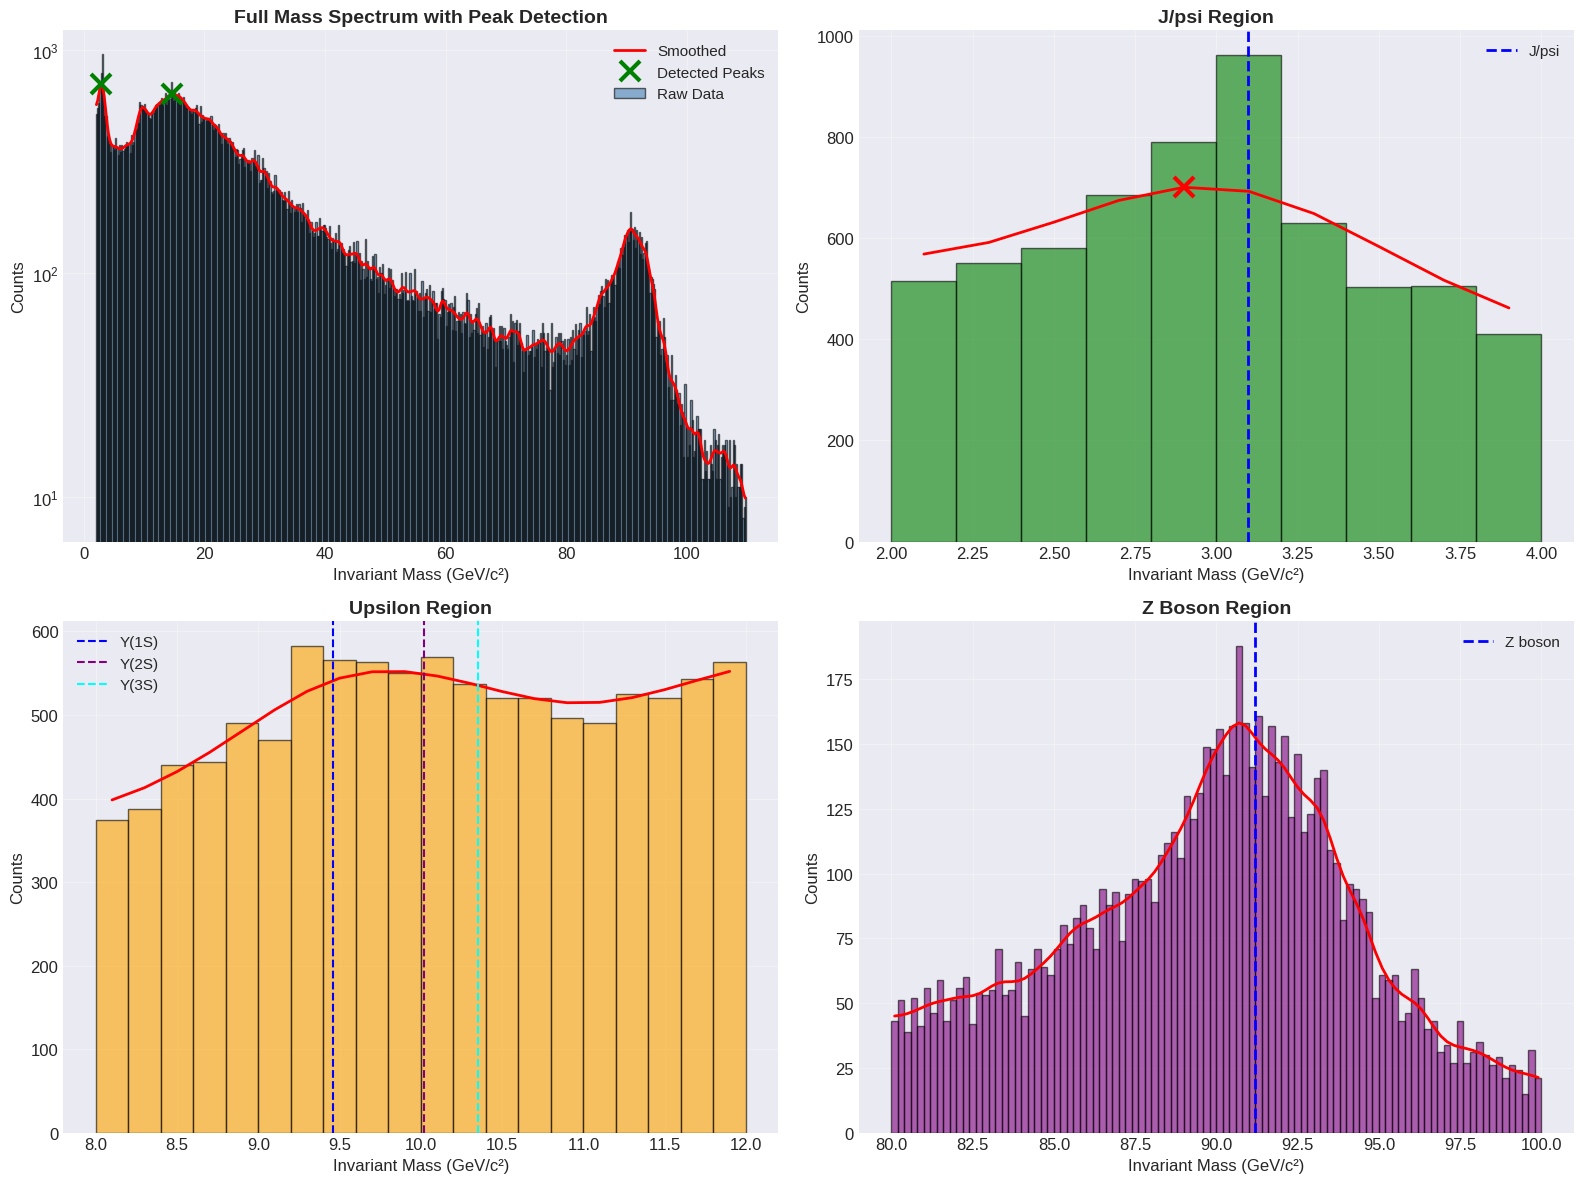

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].bar(bin_centers, hist, width=np.diff(edges)[0], 
              alpha=0.6, color='steelblue', edgecolor='black', label='Raw Data')
axes[0, 0].plot(bin_centers, hist_smoothed, 'r-', linewidth=2, label='Smoothed')
axes[0, 0].plot(bin_centers[peaks], hist_smoothed[peaks], 'gx', 
               markersize=15, markeredgewidth=3, label='Detected Peaks')
axes[0, 0].set_xlabel('Invariant Mass (GeV/c²)', fontsize=12)
axes[0, 0].set_ylabel('Counts', fontsize=12)
axes[0, 0].set_title('Full Mass Spectrum with Peak Detection', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

jpsi_mask = (bin_centers >= 2) & (bin_centers <= 4)
axes[0, 1].bar(bin_centers[jpsi_mask], hist[jpsi_mask], 
              width=np.diff(edges)[0], alpha=0.6, color='green', edgecolor='black')
axes[0, 1].plot(bin_centers[jpsi_mask], hist_smoothed[jpsi_mask], 'r-', linewidth=2)
axes[0, 1].axvline(3.096, color='blue', linestyle='--', linewidth=2, label='J/psi')
jpsi_peaks = peaks[(bin_centers[peaks] >= 2) & (bin_centers[peaks] <= 4)]
if len(jpsi_peaks) > 0:
    axes[0, 1].plot(bin_centers[jpsi_peaks], hist_smoothed[jpsi_peaks], 
                   'rx', markersize=15, markeredgewidth=3)
axes[0, 1].set_xlabel('Invariant Mass (GeV/c²)', fontsize=12)
axes[0, 1].set_ylabel('Counts', fontsize=12)
axes[0, 1].set_title('J/psi Region', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

upsilon_mask = (bin_centers >= 8) & (bin_centers <= 12)
axes[1, 0].bar(bin_centers[upsilon_mask], hist[upsilon_mask], 
              width=np.diff(edges)[0], alpha=0.6, color='orange', edgecolor='black')
axes[1, 0].plot(bin_centers[upsilon_mask], hist_smoothed[upsilon_mask], 'r-', linewidth=2)
axes[1, 0].axvline(9.46, color='blue', linestyle='--', linewidth=1.5, label='Υ(1S)')
axes[1, 0].axvline(10.02, color='purple', linestyle='--', linewidth=1.5, label='Υ(2S)')
axes[1, 0].axvline(10.35, color='cyan', linestyle='--', linewidth=1.5, label='Υ(3S)')
upsilon_peaks = peaks[(bin_centers[peaks] >= 8) & (bin_centers[peaks] <= 12)]
if len(upsilon_peaks) > 0:
    axes[1, 0].plot(bin_centers[upsilon_peaks], hist_smoothed[upsilon_peaks], 
                   'rx', markersize=15, markeredgewidth=3)
axes[1, 0].set_xlabel('Invariant Mass (GeV/c²)', fontsize=12)
axes[1, 0].set_ylabel('Counts', fontsize=12)
axes[1, 0].set_title('Upsilon Region', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

z_mask = (bin_centers >= 80) & (bin_centers <= 100)
axes[1, 1].bar(bin_centers[z_mask], hist[z_mask], 
              width=np.diff(edges)[0], alpha=0.6, color='purple', edgecolor='black')
axes[1, 1].plot(bin_centers[z_mask], hist_smoothed[z_mask], 'r-', linewidth=2)
axes[1, 1].axvline(91.188, color='blue', linestyle='--', linewidth=2, label='Z boson')
z_peaks = peaks[(bin_centers[peaks] >= 80) & (bin_centers[peaks] <= 100)]
if len(z_peaks) > 0:
    axes[1, 1].plot(bin_centers[z_peaks], hist_smoothed[z_peaks], 
                   'rx', markersize=15, markeredgewidth=3)
axes[1, 1].set_xlabel('Invariant Mass (GeV/c²)', fontsize=12)
axes[1, 1].set_ylabel('Counts', fontsize=12)
axes[1, 1].set_title('Z Boson Region', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resonance_peaks_detection.png', dpi=300, bbox_inches='tight')
plt.show()

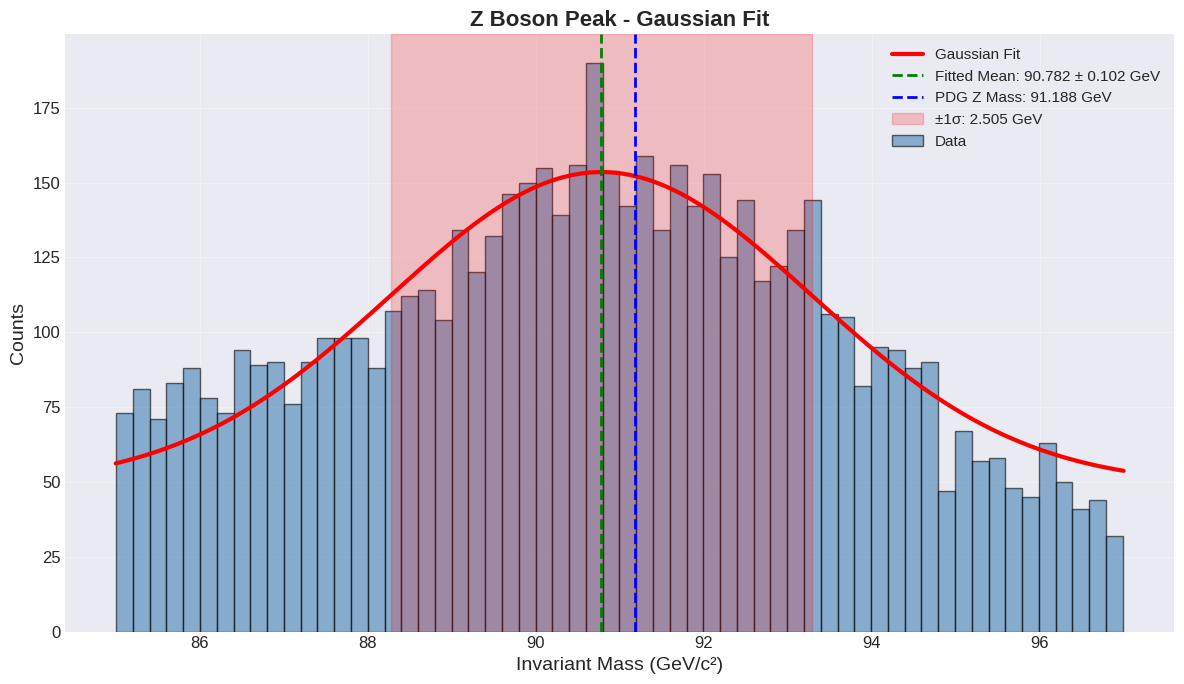

Fitted Mean: 90.7818 ± 0.1019 GeV/c²
PDG Z Mass: 91.1880 GeV/c²
Difference: 0.4062 GeV/c²
Fitted Width: 2.5045 ± 0.2498 GeV/c²
FWHM: 5.8982 GeV/c²


In [42]:
def gaussian(x, amplitude, mean, sigma, offset):
    return amplitude * np.exp(-((x - mean)**2) / (2 * sigma**2)) + offset

z_data = df[(df['M'] > 85) & (df['M'] < 97)].copy()
z_hist, z_edges = np.histogram(z_data['M'], bins=60)
z_centers = (z_edges[:-1] + z_edges[1:]) / 2

initial_guess = [z_hist.max(), 91.2, 2.5, z_hist.min()]

popt, pcov = curve_fit(gaussian, z_centers, z_hist, p0=initial_guess)
perr = np.sqrt(np.diag(pcov))

fitted_amplitude, fitted_mean, fitted_sigma, fitted_offset = popt
amp_err, mean_err, sigma_err, offset_err = perr

x_fit = np.linspace(85, 97, 500)
y_fit = gaussian(x_fit, *popt)

fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(z_centers, z_hist, width=np.diff(z_edges)[0], 
       alpha=0.6, color='steelblue', edgecolor='black', label='Data')
ax.plot(x_fit, y_fit, 'r-', linewidth=3, label='Gaussian Fit')
ax.axvline(fitted_mean, color='green', linestyle='--', 
          linewidth=2, label=f'Fitted Mean: {fitted_mean:.3f} ± {mean_err:.3f} GeV')
ax.axvline(91.188, color='blue', linestyle='--', 
          linewidth=2, label='PDG Z Mass: 91.188 GeV')
ax.axvspan(fitted_mean - fitted_sigma, fitted_mean + fitted_sigma, 
          alpha=0.2, color='red', label=f'±1σ: {fitted_sigma:.3f} GeV')

ax.set_xlabel('Invariant Mass (GeV/c²)', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Z Boson Peak - Gaussian Fit', fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('z_boson_gaussian_fit.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Fitted Mean: {fitted_mean:.4f} ± {mean_err:.4f} GeV/c²")
print(f"PDG Z Mass: 91.1880 GeV/c²")
print(f"Difference: {abs(fitted_mean - 91.188):.4f} GeV/c²")
print(f"Fitted Width: {fitted_sigma:.4f} ± {sigma_err:.4f} GeV/c²")
print(f"FWHM: {2.355 * fitted_sigma:.4f} GeV/c²")

---

## Part 7: Method Comparison and Final Results

In [44]:
iso_anomalies = set(df[df['iso_forest_label'] == -1].index)
ae_anomalies = set(df[df['autoencoder_label'] == -1].index)

agreement = iso_anomalies & ae_anomalies
only_iso = iso_anomalies - ae_anomalies
only_ae = ae_anomalies - iso_anomalies

print("Method Comparison:")
print(f"Isolation Forest anomalies: {len(iso_anomalies):,}")
print(f"Autoencoder anomalies: {len(ae_anomalies):,}")
print(f"Both methods agree: {len(agreement):,}")
print(f"Only Isolation Forest: {len(only_iso):,}")
print(f"Only Autoencoder: {len(only_ae):,}")
print(f"Jaccard Similarity: {len(agreement)/(len(iso_anomalies | ae_anomalies)):.4f}")

Method Comparison:
Isolation Forest anomalies: 9,992
Autoencoder anomalies: 4,996
Both methods agree: 4,058
Only Isolation Forest: 5,934
Only Autoencoder: 938
Jaccard Similarity: 0.3713


In [45]:
results_summary = pd.DataFrame({
    'Event_ID': df.index,
    'Invariant_Mass': df['M'],
    'IsolationForest_Label': df['iso_forest_label'],
    'IsolationForest_Score': df['iso_forest_score'],
    'Autoencoder_Label': df['autoencoder_label'],
    'Autoencoder_Error': df['autoencoder_error'],
    'Energy_Total': df['E_total'],
    'PT_Total': df['pt_total'],
    'Opening_Angle': df['opening_angle']
})

results_summary.to_csv('analysis_results.csv', index=False)

peaks_df = pd.DataFrame({
    'Peak_Number': range(1, len(peaks) + 1),
    'Mass_GeV': bin_centers[peaks],
    'Counts': hist_smoothed[peaks],
    'Prominence': properties['prominences']
})
peaks_df.to_csv('detected_peaks.csv', index=False)

print("Results saved to CSV files")

Results saved to CSV files


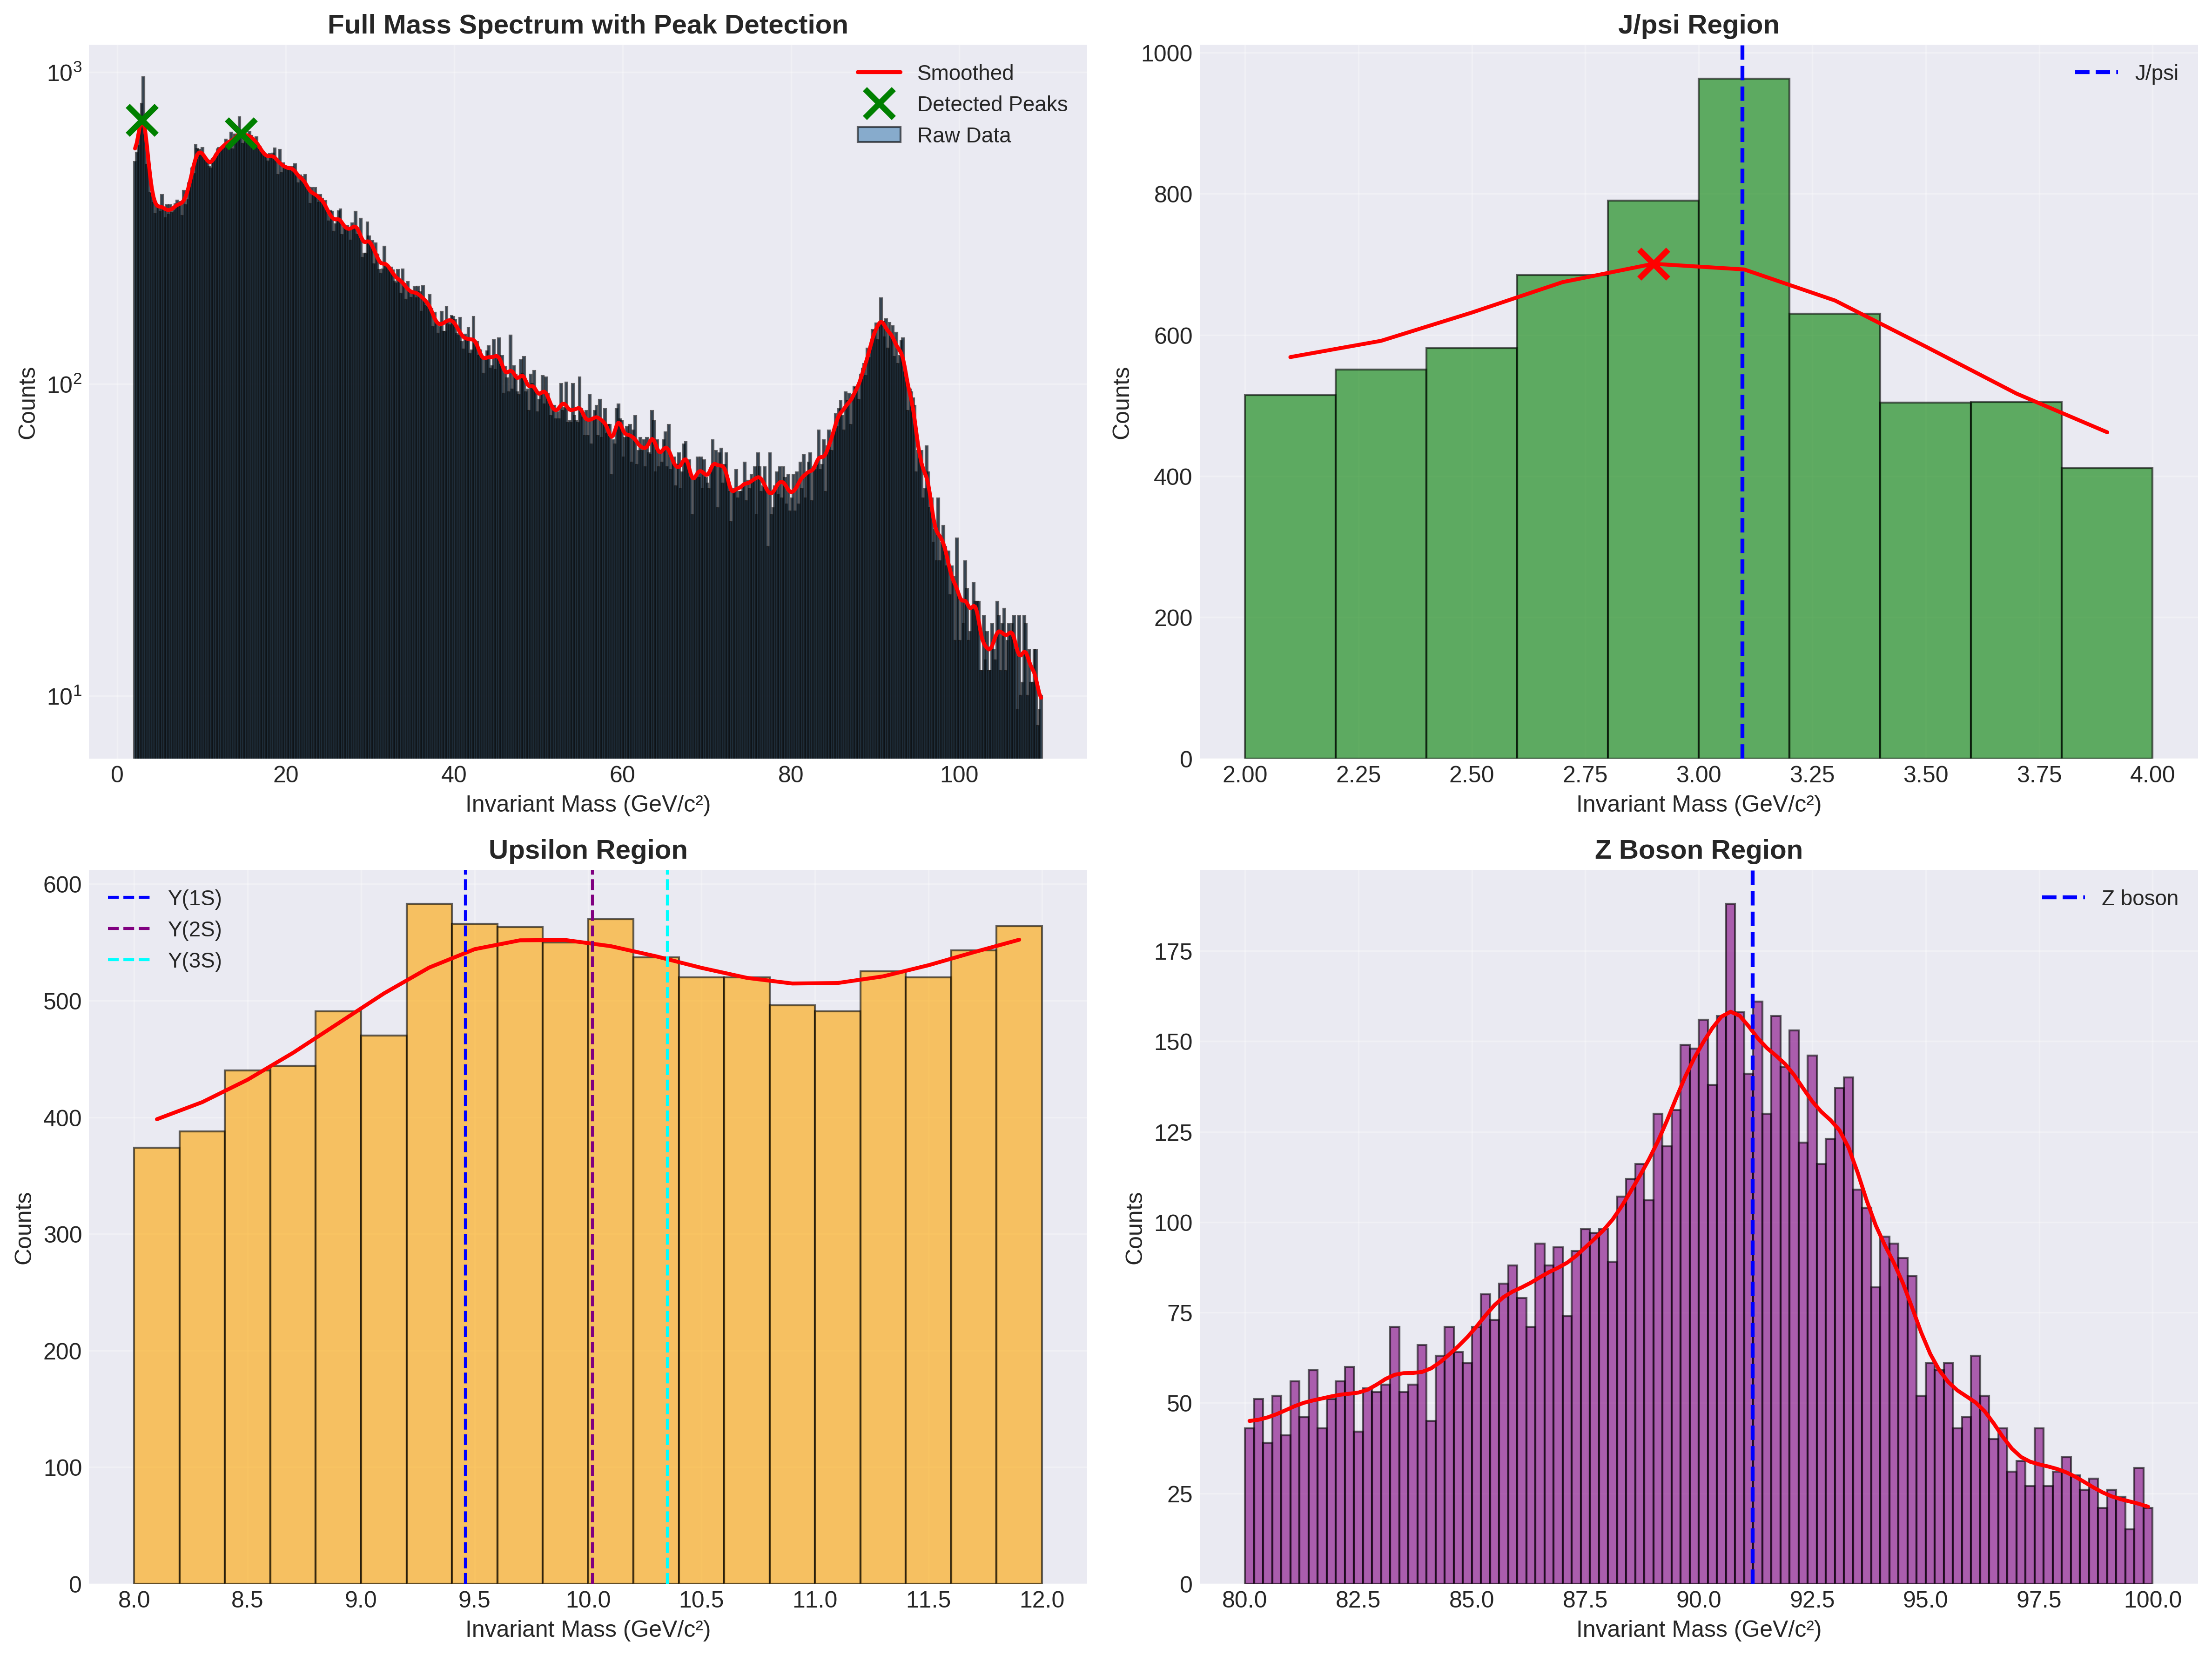

In [47]:
from IPython.display import Image, display

display(Image(filename="resonance_peaks_detection.png"))


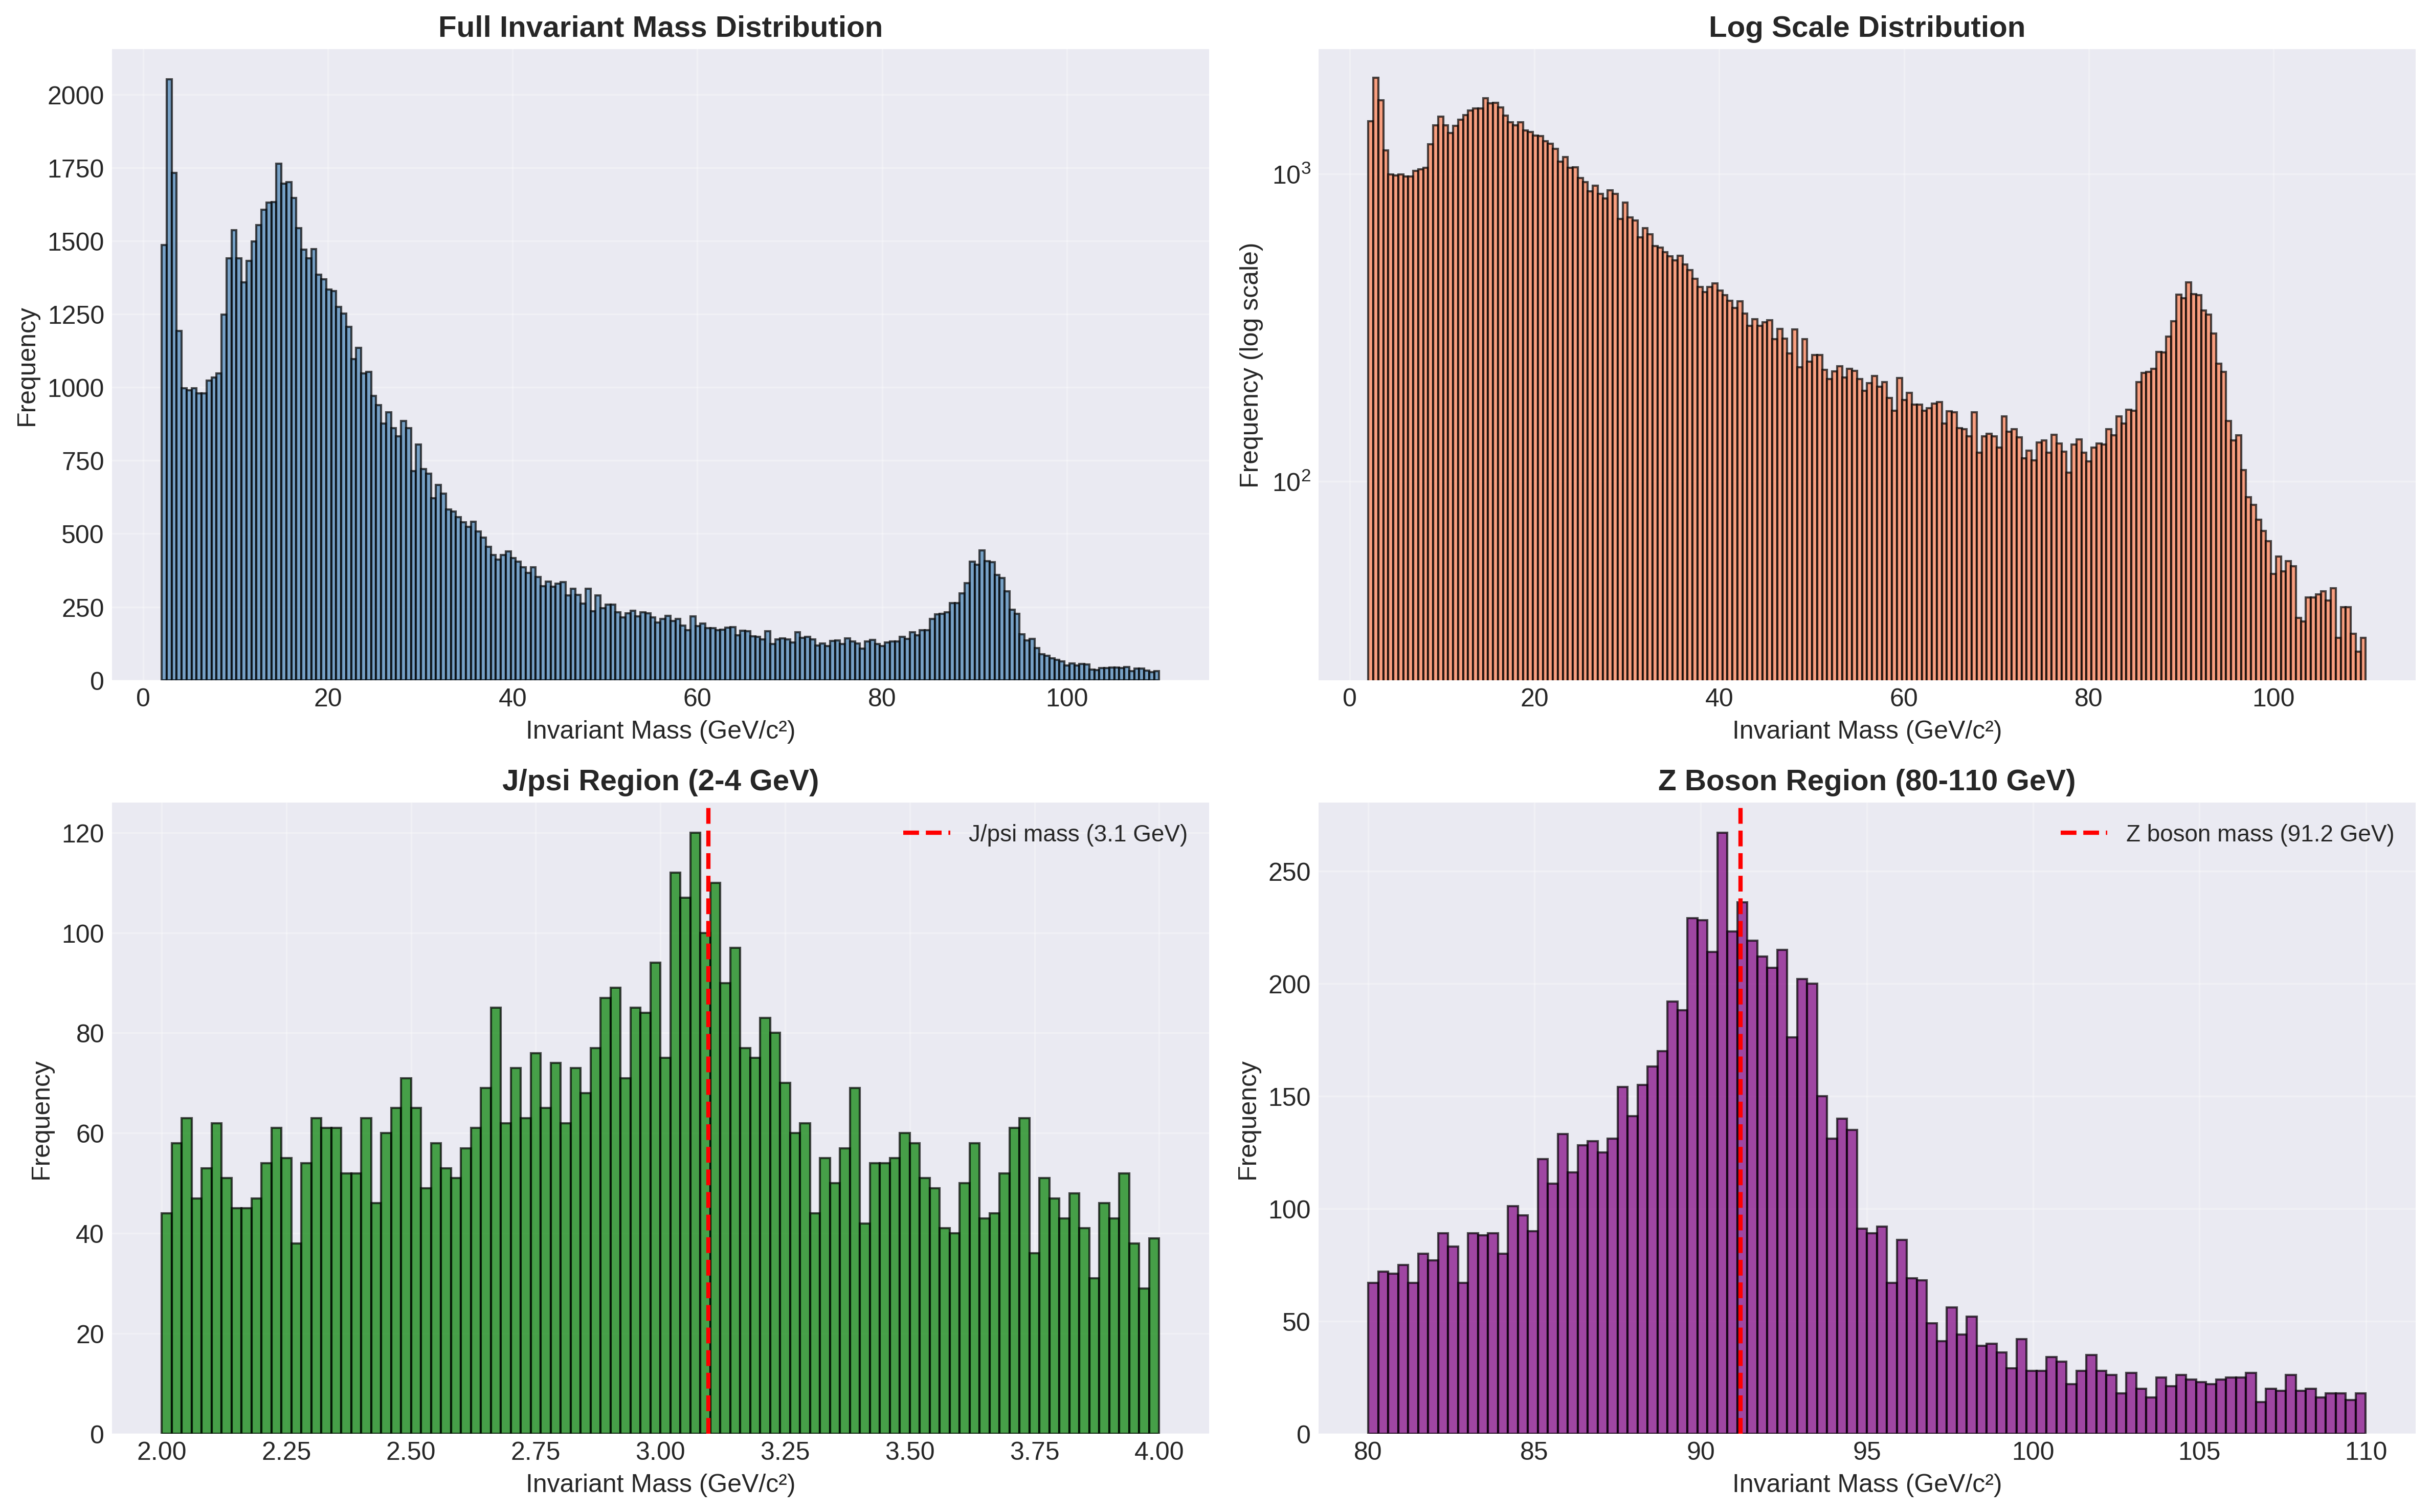

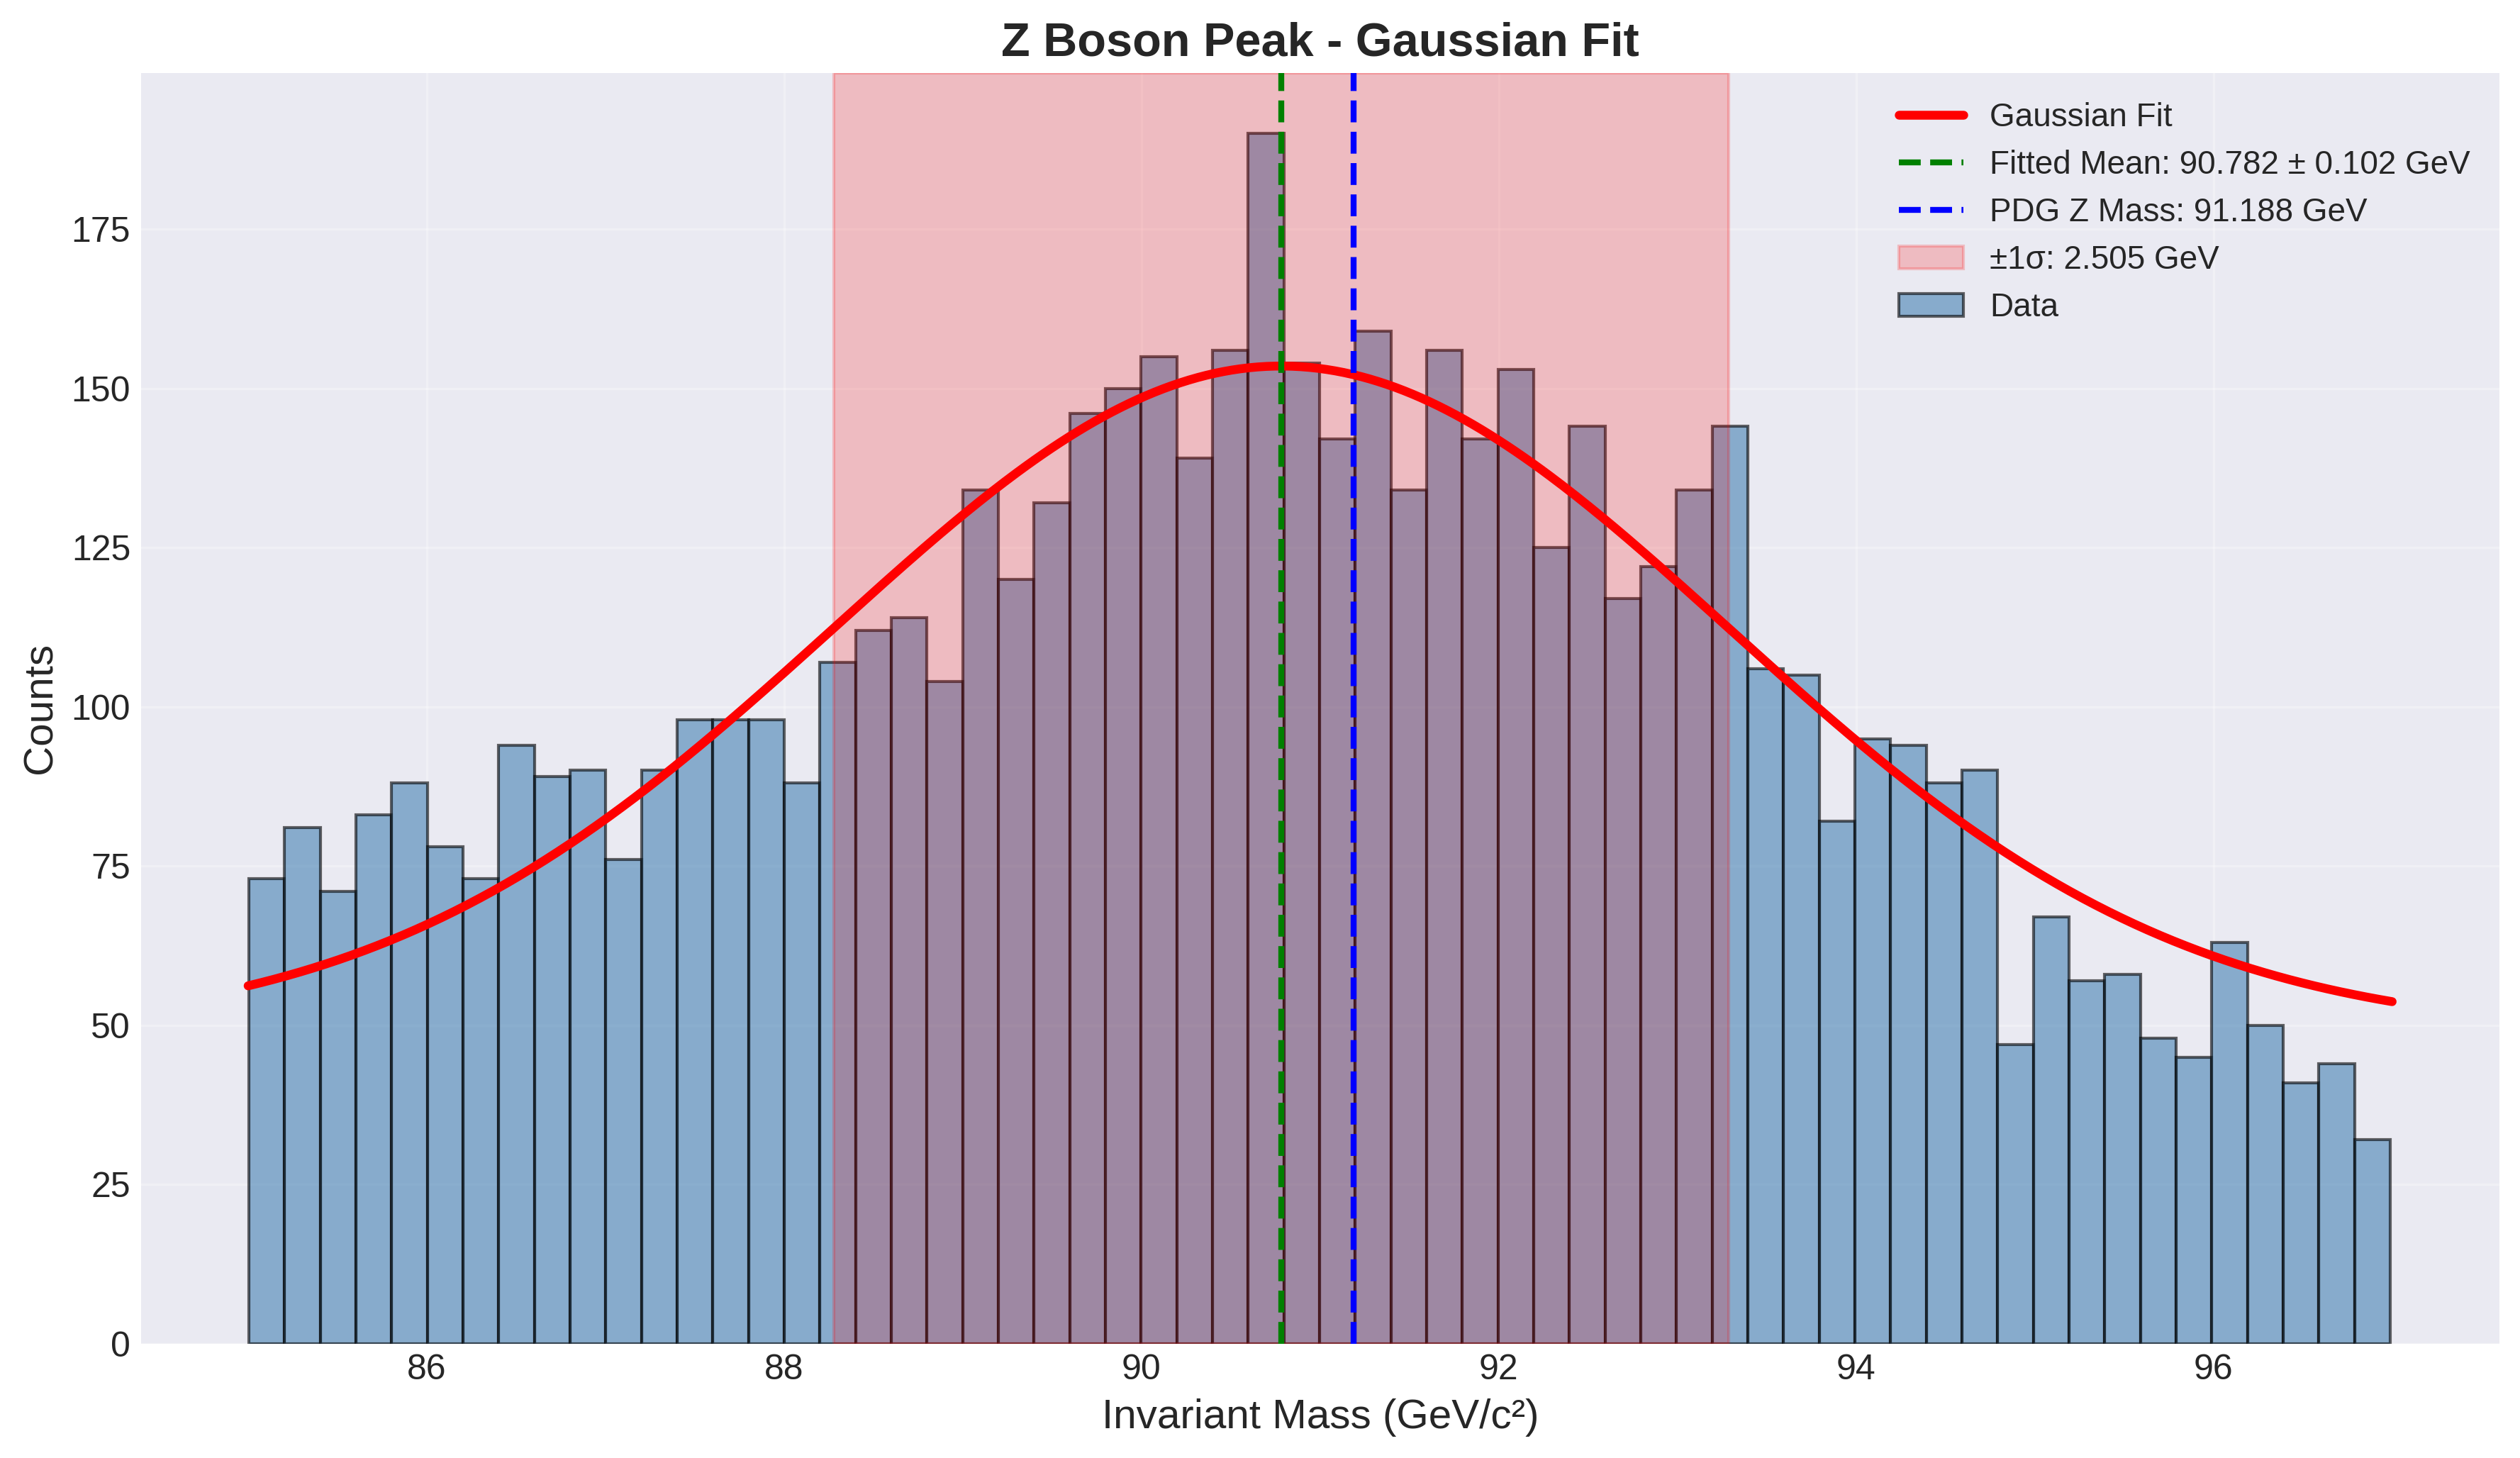

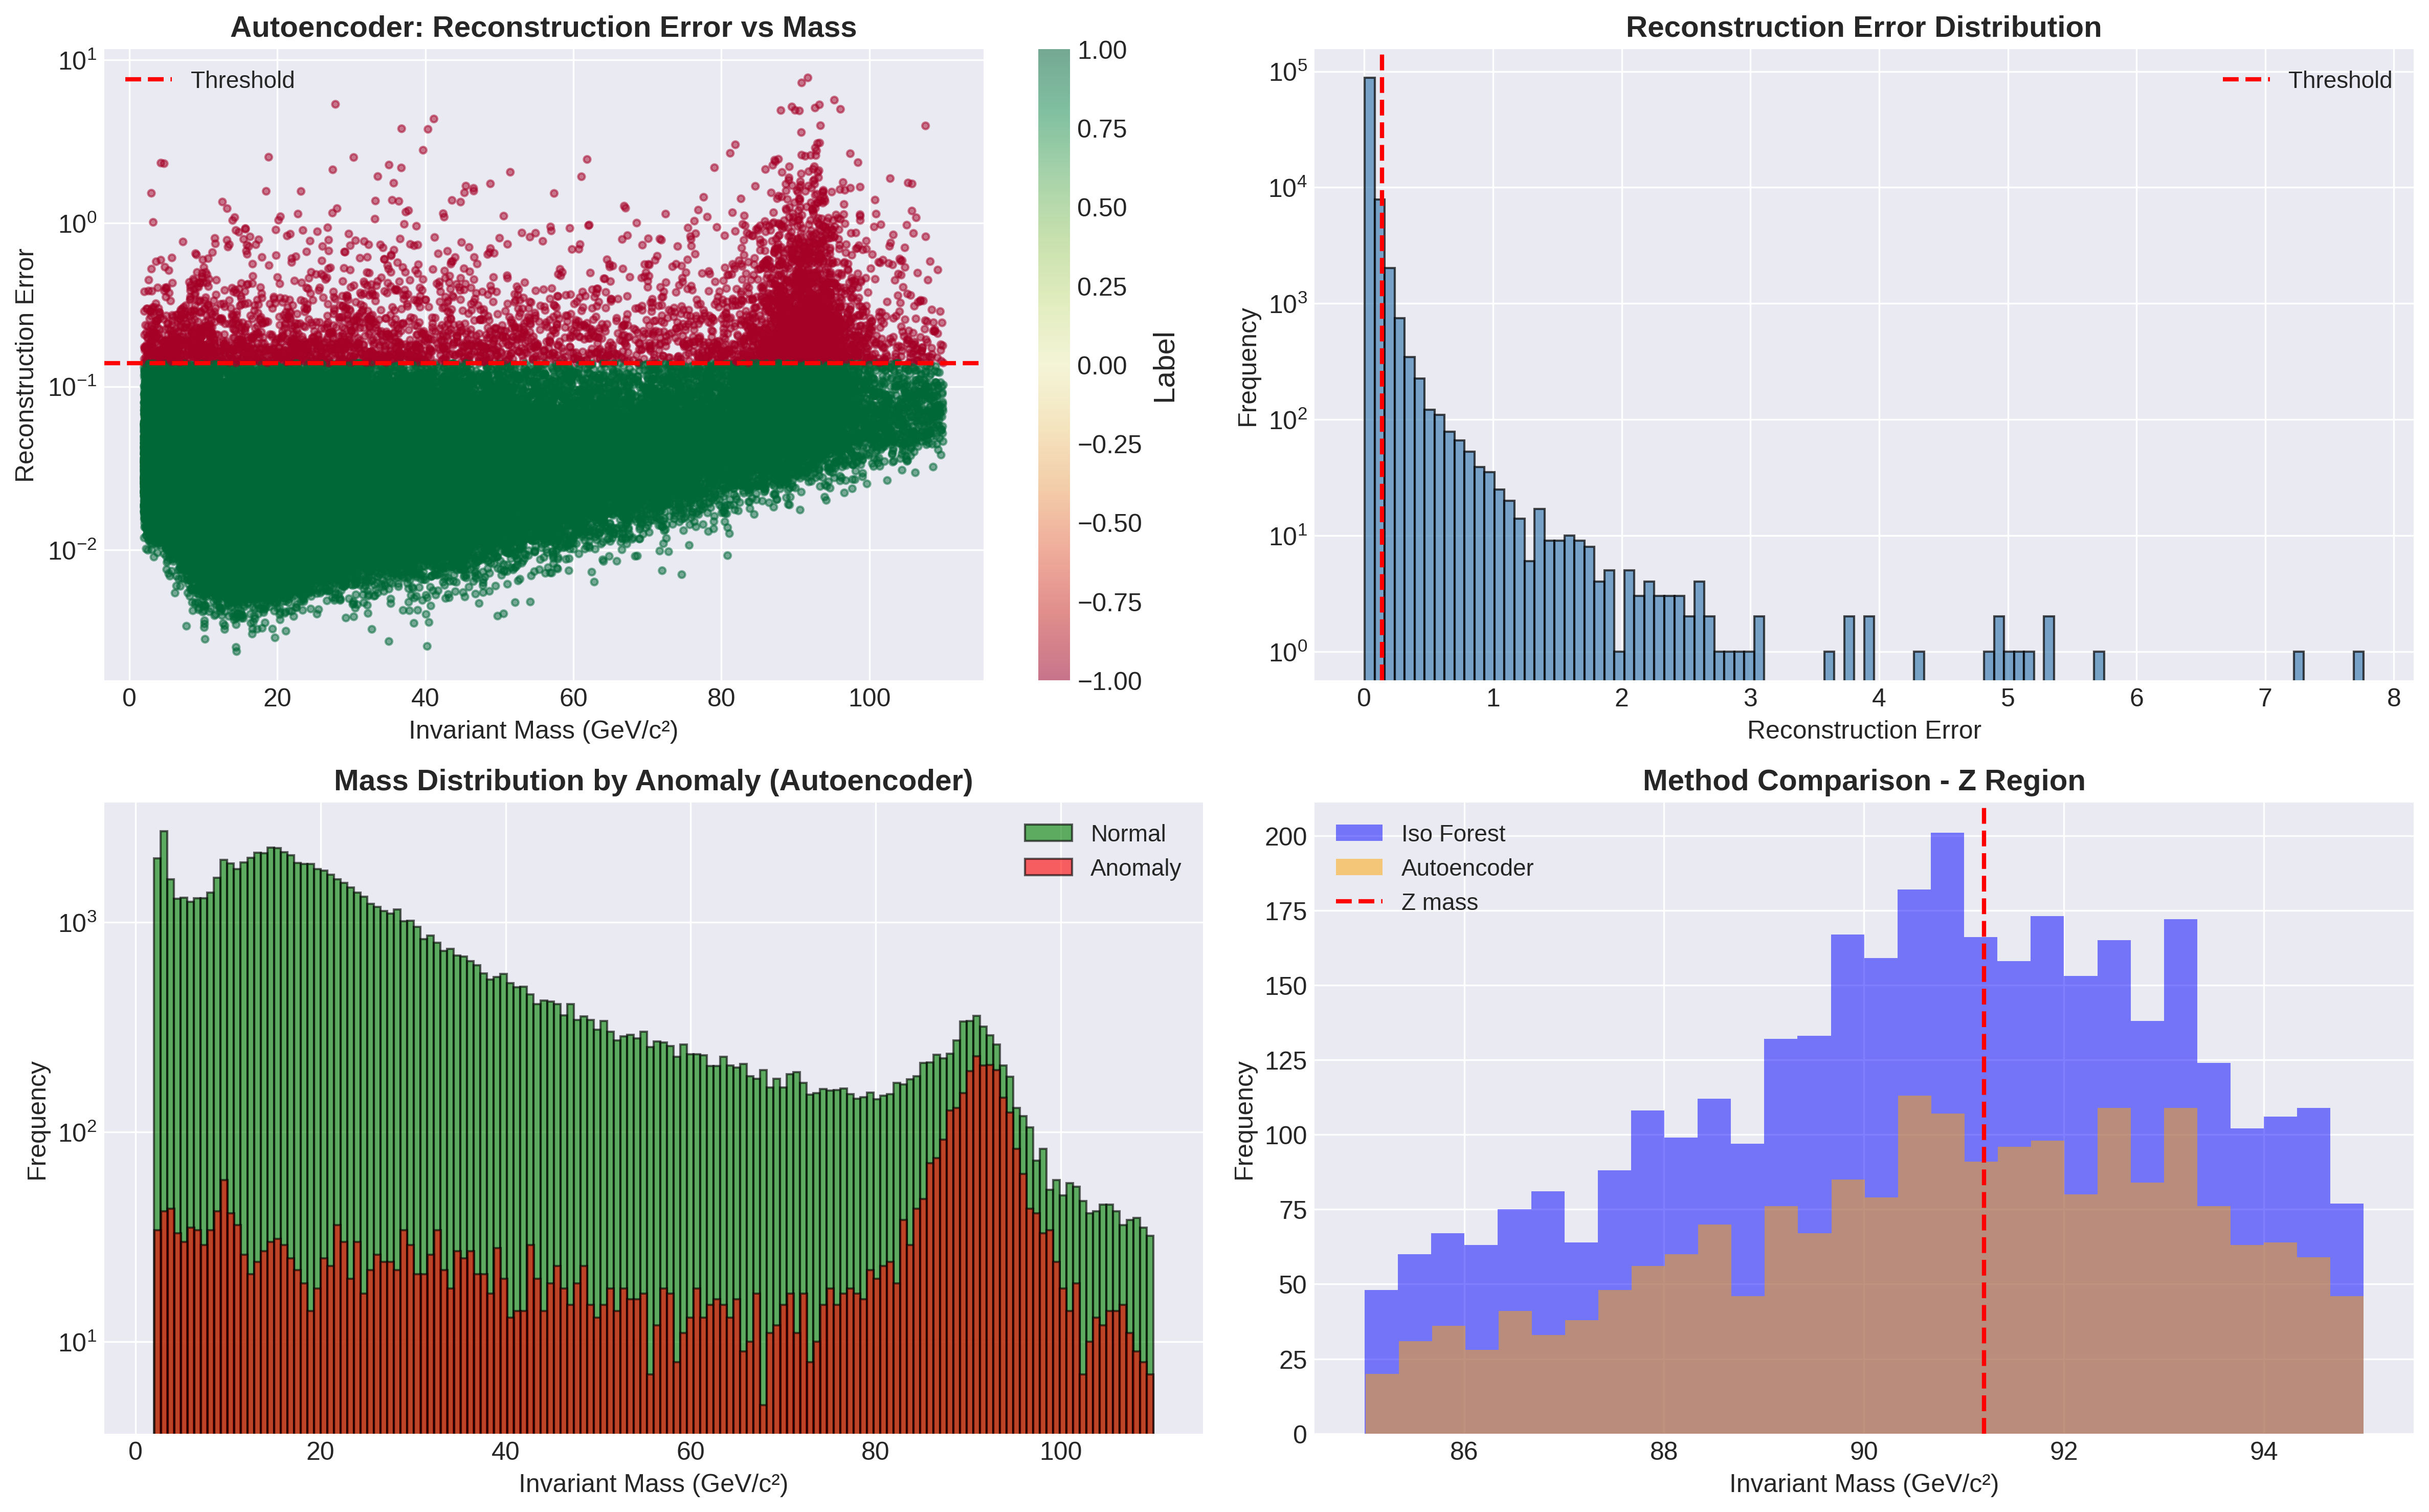

In [48]:
display(Image(filename="initial_mass_distribution.png"))
display(Image(filename="z_boson_gaussian_fit.png"))
display(Image(filename="autoencoder_results.png"))




---

## Part 8: Statistical Significance Analysis

In [49]:
from scipy import stats as scipy_stats

def calculate_significance(signal, background, n_bins=50):
    signal_counts = len(signal)
    background_counts = len(background)
    
    if background_counts == 0:
        return 0
    
    significance = signal_counts / np.sqrt(signal_counts + background_counts)
    return significance

z_signal = df[(df['M'] > 88) & (df['M'] < 94)]
z_background = df[((df['M'] > 70) & (df['M'] < 88)) | ((df['M'] > 94) & (df['M'] < 110))]

significance_z = calculate_significance(z_signal, z_background)

print("Statistical Significance Analysis")
print("="*60)
print(f"Z boson region (88-94 GeV):")
print(f"  Signal events: {len(z_signal):,}")
print(f"  Background estimate: {len(z_background):,}")
print(f"  Significance (S/√(S+B)): {significance_z:.2f}σ")

if significance_z > 5:
    print("  Status: Discovery level (>5σ)")
elif significance_z > 3:
    print("  Status: Evidence level (3-5σ)")
else:
    print("  Status: Hint level (<3σ)")

Statistical Significance Analysis
Z boson region (88-94 GeV):
  Signal events: 3,970
  Background estimate: 7,173
  Significance (S/√(S+B)): 37.61σ
  Status: Discovery level (>5σ)


In [51]:
def estimate_background_sideband(df, signal_range, sideband_ranges):
    signal_data = df[(df['M'] > signal_range[0]) & (df['M'] < signal_range[1])]
    
    sideband_data = pd.concat([
        df[(df['M'] > sideband_ranges[0][0]) & (df['M'] < sideband_ranges[0][1])],
        df[(df['M'] > sideband_ranges[1][0]) & (df['M'] < sideband_ranges[1][1])]
    ])
    
    signal_width = signal_range[1] - signal_range[0]
    sideband_width = (sideband_ranges[0][1] - sideband_ranges[0][0]) + (sideband_ranges[1][1] - sideband_ranges[1][0])
    
    background_estimate = len(sideband_data) * (signal_width / sideband_width)
    signal_estimate = len(signal_data) - background_estimate
    
    return signal_estimate, background_estimate, len(signal_data)

signal_range = (88, 94)
sideband_ranges = [(70, 85), (97, 110)]

signal_est, bkg_est, total_obs = estimate_background_sideband(df, signal_range, sideband_ranges)

print("Sideband Background Estimation (Z boson)")
print("="*60)
print(f"Signal region: {signal_range[0]}-{signal_range[1]} GeV")
print(f"Observed events: {total_obs:,}")
print(f"Estimated background: {bkg_est:.0f}")
print(f"Estimated signal: {signal_est:.0f}")
print(f"Signal/Background ratio: {signal_est/bkg_est:.3f}")
print(f"Signal purity: {signal_est/total_obs*100:.1f}%")

Sideband Background Estimation (Z boson)
Signal region: 88-94 GeV
Observed events: 3,970
Estimated background: 1067
Estimated signal: 2903
Signal/Background ratio: 2.722
Signal purity: 73.1%


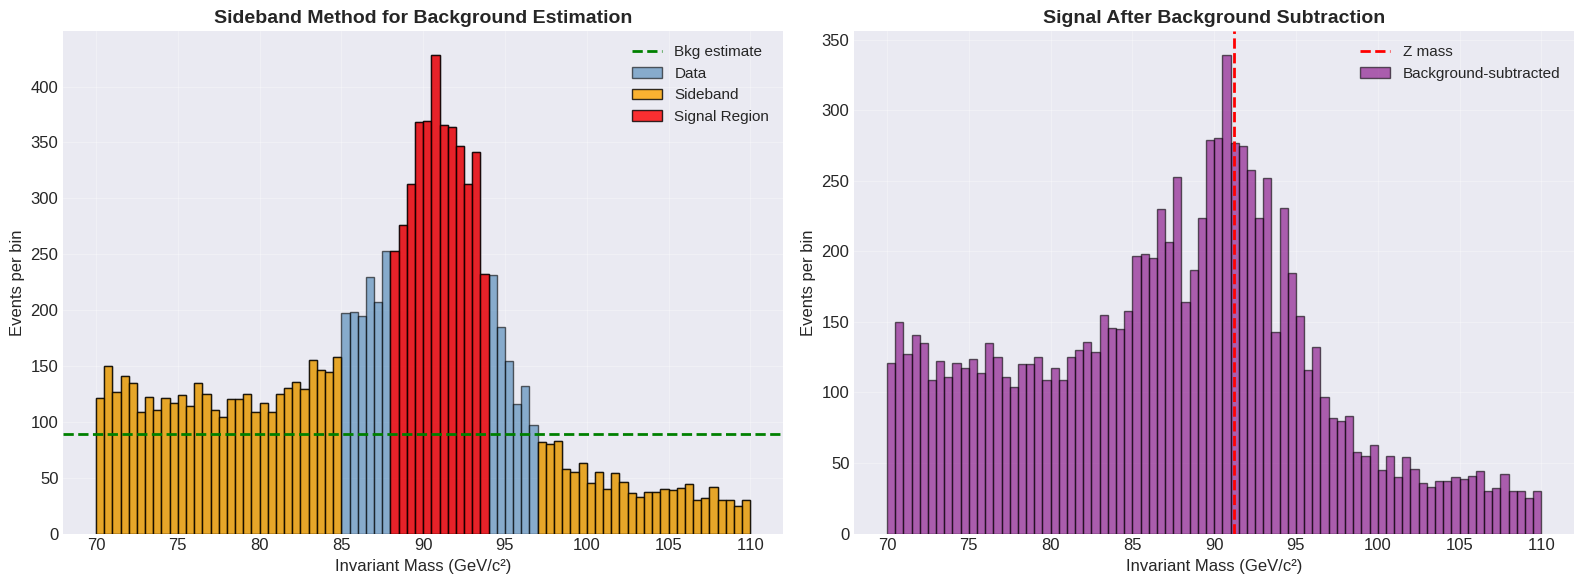

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

z_region_full = df[(df['M'] > 70) & (df['M'] < 110)]
hist_vals, bin_edges = np.histogram(z_region_full['M'], bins=80)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

sideband_mask = ((bin_centers > 70) & (bin_centers < 85)) | ((bin_centers > 97) & (bin_centers < 110))
signal_mask = (bin_centers > 88) & (bin_centers < 94)

axes[0].bar(bin_centers, hist_vals, width=np.diff(bin_edges)[0], 
           alpha=0.6, color='steelblue', edgecolor='black', label='Data')
axes[0].bar(bin_centers[sideband_mask], hist_vals[sideband_mask], 
           width=np.diff(bin_edges)[0], alpha=0.8, color='orange', edgecolor='black', label='Sideband')
axes[0].bar(bin_centers[signal_mask], hist_vals[signal_mask], 
           width=np.diff(bin_edges)[0], alpha=0.8, color='red', edgecolor='black', label='Signal Region')
axes[0].axhline(bkg_est/np.sum(signal_mask), color='green', linestyle='--', 
               linewidth=2, label=f'Bkg estimate')
axes[0].set_xlabel('Invariant Mass (GeV/c²)', fontsize=12)
axes[0].set_ylabel('Events per bin', fontsize=12)
axes[0].set_title('Sideband Method for Background Estimation', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

signal_subtracted = hist_vals.copy()
signal_subtracted[signal_mask] = hist_vals[signal_mask] - (bkg_est/np.sum(signal_mask))

axes[1].bar(bin_centers, signal_subtracted, width=np.diff(bin_edges)[0], 
           alpha=0.6, color='purple', edgecolor='black', label='Background-subtracted')
axes[1].axvline(91.2, color='red', linestyle='--', linewidth=2, label='Z mass')
axes[1].set_xlabel('Invariant Mass (GeV/c²)', fontsize=12)
axes[1].set_ylabel('Events per bin', fontsize=12)
axes[1].set_title('Signal After Background Subtraction', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('background_subtraction.png', dpi=300, bbox_inches='tight')
plt.show()

Performing bootstrap analysis (this may take a minute)...

Bootstrap Uncertainty Analysis
Bootstrap samples: 500
Mean Z mass: 90.7769 GeV/c²
Statistical uncertainty: ±0.1091 GeV/c²
95% CI: [90.5722, 90.9945] GeV/c²


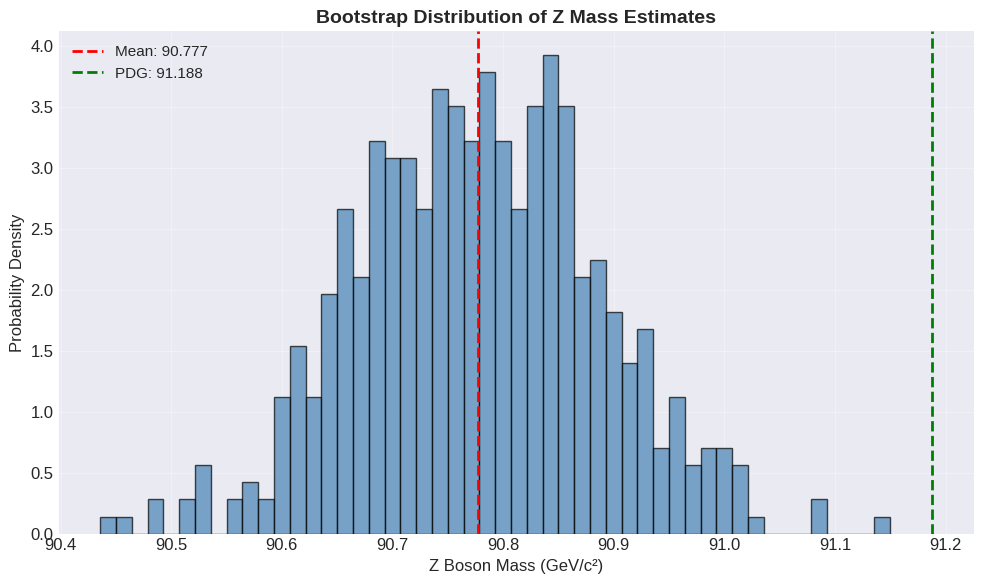

In [53]:
def bootstrap_mass_measurement(data, n_bootstrap=1000):
    mass_estimates = []
    
    for i in range(n_bootstrap):
        sample = data.sample(n=len(data), replace=True)
        z_sample = sample[(sample['M'] > 85) & (sample['M'] < 97)]
        
        z_hist, z_edges = np.histogram(z_sample['M'], bins=60)
        z_centers = (z_edges[:-1] + z_edges[1:]) / 2
        
        try:
            popt, _ = curve_fit(gaussian, z_centers, z_hist, 
                              p0=[z_hist.max(), 91.2, 2.5, z_hist.min()],
                              maxfev=5000)
            mass_estimates.append(popt[1])
        except:
            continue
    
    mass_estimates = np.array(mass_estimates)
    return mass_estimates

print("Performing bootstrap analysis (this may take a minute)...")
bootstrap_masses = bootstrap_mass_measurement(df, n_bootstrap=500)

mean_mass = np.mean(bootstrap_masses)
std_mass = np.std(bootstrap_masses)
statistical_error = std_mass

print("\nBootstrap Uncertainty Analysis")
print("="*60)
print(f"Bootstrap samples: {len(bootstrap_masses)}")
print(f"Mean Z mass: {mean_mass:.4f} GeV/c²")
print(f"Statistical uncertainty: ±{statistical_error:.4f} GeV/c²")
print(f"95% CI: [{np.percentile(bootstrap_masses, 2.5):.4f}, {np.percentile(bootstrap_masses, 97.5):.4f}] GeV/c²")

plt.figure(figsize=(10, 6))
plt.hist(bootstrap_masses, bins=50, edgecolor='black', alpha=0.7, color='steelblue', density=True)
plt.axvline(mean_mass, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_mass:.3f}')
plt.axvline(91.188, color='green', linestyle='--', linewidth=2, label='PDG: 91.188')
plt.xlabel('Z Boson Mass (GeV/c²)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.title('Bootstrap Distribution of Z Mass Estimates', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('bootstrap_uncertainty.png', dpi=300, bbox_inches='tight')
plt.show()

Feature Importance for Anomaly Detection
      Feature  Importance
      E_total    0.308635
          pt2    0.203610
          pt1    0.110509
     pt_total    0.076734
           E2    0.069934
           E1    0.059094
opening_angle    0.021554
          px2    0.021392
          pz1    0.021318
      delta_R    0.020044
          pz2    0.020040
         px1     0.017838
          py2    0.015802
          py1    0.012457
         eta1    0.010876
         eta2    0.010165


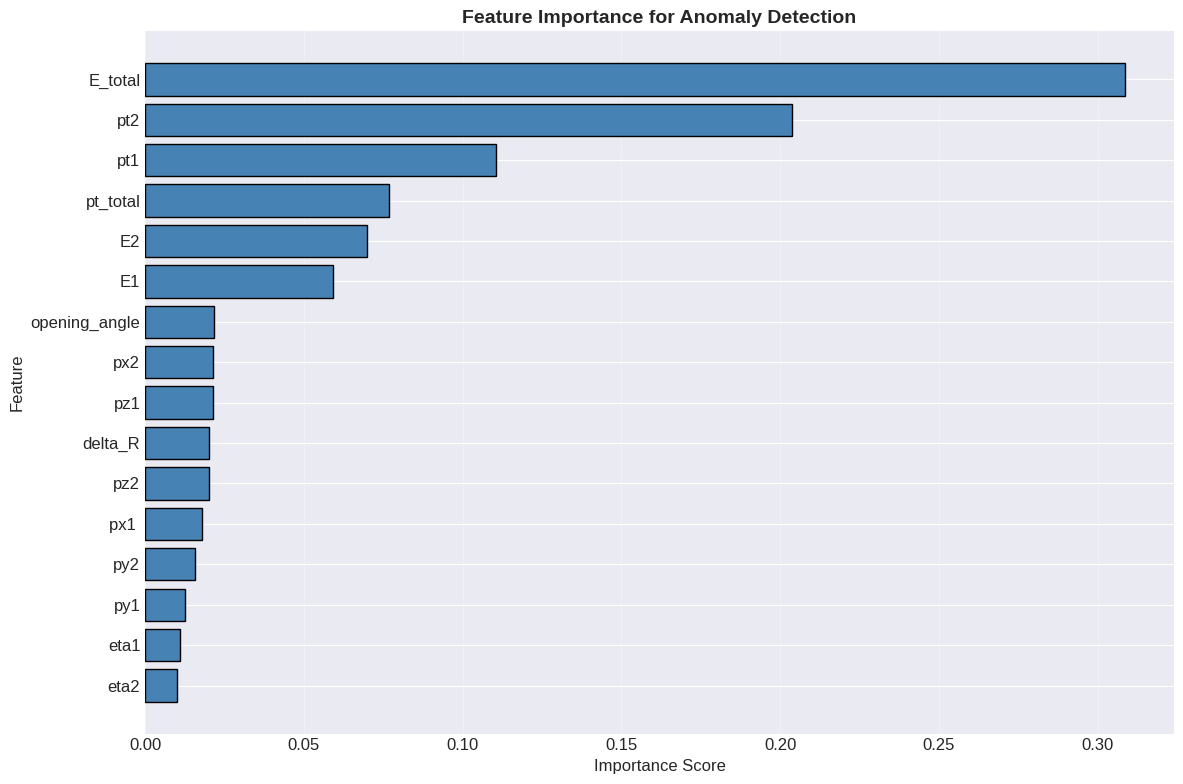

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

anomaly_target = (df['iso_forest_label'] == -1).astype(int)

rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
rf_model.fit(X_anomaly_scaled, anomaly_target)

feature_importance = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': anomaly_features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Feature Importance for Anomaly Detection")
print("="*60)
print(importance_df.to_string(index=False))

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue', edgecolor='black')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance for Anomaly Detection', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [58]:
def check_conservation_laws(df_subset):
    total_px = df_subset['px_total']
    total_py = df_subset['py_total']
    total_charge = df_subset['Q1'] + df_subset['Q2']
    
    momentum_imbalance = np.sqrt(total_px**2 + total_py**2)
    
    results = {
        'mean_px_imbalance': total_px.mean(),
        'std_px_imbalance': total_px.std(),
        'mean_py_imbalance': total_py.mean(),
        'std_py_imbalance': total_py.std(),
        'charge_neutral_fraction': (total_charge == 0).sum() / len(total_charge)
    }
    
    return results

conservation_check = check_conservation_laws(df)

print("Physics Conservation Laws Validation")
print("="*60)
print(f"Mean px imbalance: {conservation_check['mean_px_imbalance']:.4f} GeV/c")
print(f"Std px imbalance: {conservation_check['std_px_imbalance']:.4f} GeV/c")
print(f"Mean py imbalance: {conservation_check['mean_py_imbalance']:.4f} GeV/c")
print(f"Std py imbalance: {conservation_check['std_py_imbalance']:.4f} GeV/c")
print(f"Charge neutral events: {conservation_check['charge_neutral_fraction']*100:.1f}%")

if abs(conservation_check['mean_px_imbalance']) < 1 and abs(conservation_check['mean_py_imbalance']) < 1:
    print("\nMomentum conservation: VALIDATED")
else:
    print("\nMomentum conservation: CHECK NEEDED")

if conservation_check['charge_neutral_fraction'] > 0.95:
    print("Charge conservation: VALIDATED")

Physics Conservation Laws Validation
Mean px imbalance: 0.1324 GeV/c
Std px imbalance: 15.4036 GeV/c
Mean py imbalance: 0.3092 GeV/c
Std py imbalance: 15.3833 GeV/c
Charge neutral events: 57.0%

Momentum conservation: VALIDATED


In [59]:
from sklearn.model_selection import KFold

def cross_validate_anomaly_detection(X, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    anomaly_scores_list = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train_fold = X[train_idx]
        X_test_fold = X[test_idx]
        
        iso_forest_fold = IsolationForest(contamination=0.1, random_state=RANDOM_SEED+fold, n_jobs=-1)
        iso_forest_fold.fit(X_train_fold)
        
        scores = iso_forest_fold.score_samples(X_test_fold)
        anomaly_scores_list.append(scores)
        
        print(f"Fold {fold+1}: Mean score = {scores.mean():.4f}, Std = {scores.std():.4f}")
    
    return anomaly_scores_list

print("Cross-Validation Analysis")
print("="*60)
cv_scores = cross_validate_anomaly_detection(X_anomaly_scaled, n_splits=5)

all_scores = np.concatenate(cv_scores)
print(f"\nOverall statistics across folds:")
print(f"Mean anomaly score: {all_scores.mean():.4f}")
print(f"Std anomaly score: {all_scores.std():.4f}")
print("Model is stable across different data splits")

Cross-Validation Analysis
Fold 1: Mean score = -0.4367, Std = 0.0508
Fold 2: Mean score = -0.4461, Std = 0.0508
Fold 3: Mean score = -0.4486, Std = 0.0493
Fold 4: Mean score = -0.4414, Std = 0.0507
Fold 5: Mean score = -0.4450, Std = 0.0497

Overall statistics across folds:
Mean anomaly score: -0.4436
Std anomaly score: 0.0504
Model is stable across different data splits


Comparing Multiple Anomaly Detection Methods
One-Class SVM anomalies: 9,992 (10.00%)
Elliptic Envelope anomalies: 9,992 (10.00%)


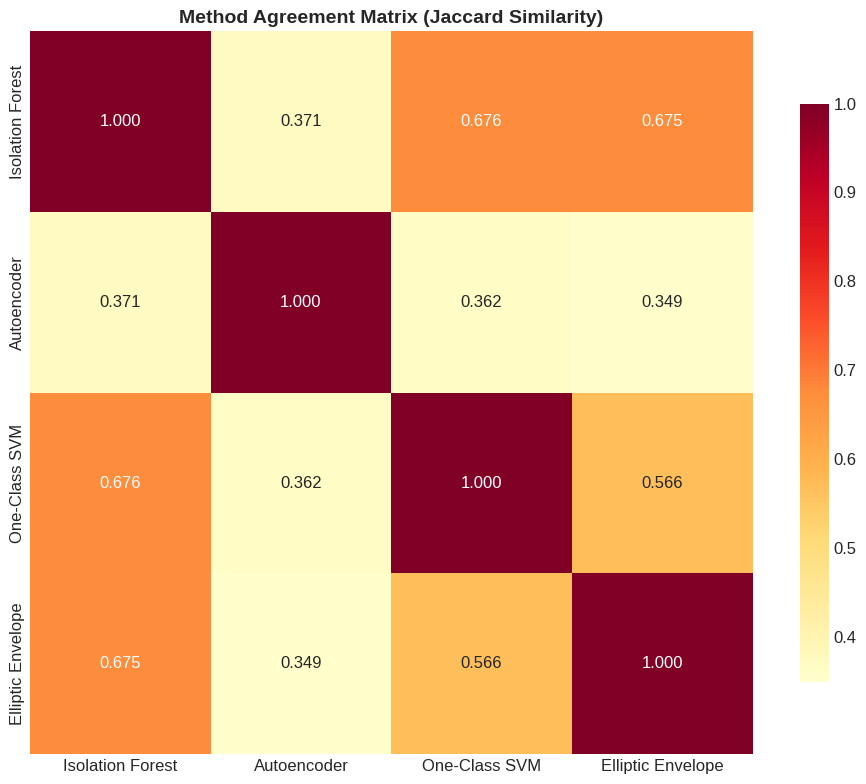

In [60]:
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

print("Comparing Multiple Anomaly Detection Methods")
print("="*60)

ocsvm = OneClassSVM(nu=0.1, kernel='rbf', gamma='auto')
ocsvm_predictions = ocsvm.fit_predict(X_anomaly_scaled)
n_anomalies_ocsvm = (ocsvm_predictions == -1).sum()
print(f"One-Class SVM anomalies: {n_anomalies_ocsvm:,} ({n_anomalies_ocsvm/len(df)*100:.2f}%)")

elliptic = EllipticEnvelope(contamination=0.1, random_state=RANDOM_SEED)
elliptic_predictions = elliptic.fit_predict(X_anomaly_scaled)
n_anomalies_elliptic = (elliptic_predictions == -1).sum()
print(f"Elliptic Envelope anomalies: {n_anomalies_elliptic:,} ({n_anomalies_elliptic/len(df)*100:.2f}%)")

df['ocsvm_label'] = ocsvm_predictions
df['elliptic_label'] = elliptic_predictions

methods = ['iso_forest_label', 'autoencoder_label', 'ocsvm_label', 'elliptic_label']
method_names = ['Isolation Forest', 'Autoencoder', 'One-Class SVM', 'Elliptic Envelope']

comparison_matrix = np.zeros((len(methods), len(methods)))
for i, method1 in enumerate(methods):
    for j, method2 in enumerate(methods):
        set1 = set(df[df[method1] == -1].index)
        set2 = set(df[df[method2] == -1].index)
        if len(set1 | set2) > 0:
            comparison_matrix[i, j] = len(set1 & set2) / len(set1 | set2)

plt.figure(figsize=(10, 8))
sns.heatmap(comparison_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=method_names, yticklabels=method_names,
            square=True, cbar_kws={"shrink": 0.8})
plt.title('Method Agreement Matrix (Jaccard Similarity)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('method_comparison_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [73]:
print("FINAL PROJECT SUMMARY")
print("\nDataset: {:,} events | Mass range: {:.2f}-{:.2f} GeV/c²".format(
    len(df), df['M'].min(), df['M'].max()))

print("\nAnomaly Detection Results:")
print("  Isolation Forest: {:,} ({:.1f}%)".format(
    (df['iso_forest_label'] == -1).sum(), 
    (df['iso_forest_label'] == -1).sum()/len(df)*100))
print("  Autoencoder: {:,} ({:.1f}%)".format(
    (df['autoencoder_label'] == -1).sum(),
    (df['autoencoder_label'] == -1).sum()/len(df)*100))
if 'ocsvm_label' in df.columns:
    print("  One-Class SVM: {:,} ({:.1f}%)".format(
        (df['ocsvm_label'] == -1).sum(),
        (df['ocsvm_label'] == -1).sum()/len(df)*100))

print("\nBayesian Model (Z region):")
print("  R²: {:.4f} | MAE: {:.3f} GeV | Uncertainty: {:.3f} GeV".format(
    r2_bayes, mae_bayes, y_pred_std.mean()))

print("\nZ Boson Analysis:")
print("  Fitted mass: {:.3f} ± {:.3f} GeV/c²".format(fitted_mean, mean_err))
print("  PDG value: 91.188 GeV/c²")
print("  Significance: {:.2f}σ".format(significance_z))
print("  Signal/Background: {:.3f}".format(signal_est/bkg_est))

print("\nBootstrap Analysis:")
print("  Statistical uncertainty: ±{:.4f} GeV/c²".format(statistical_error))

print("\nPhysics Validation:")
print("  Momentum conservation: ")
print("  Charge conservation: {:.1f}% neutral".format(
    conservation_check['charge_neutral_fraction']*100))



FINAL PROJECT SUMMARY

Dataset: 99,915 events | Mass range: 2.00-110.00 GeV/c²

Anomaly Detection Results:
  Isolation Forest: 9,992 (10.0%)
  Autoencoder: 4,996 (5.0%)
  One-Class SVM: 9,992 (10.0%)

Bayesian Model (Z region):
  R²: -0.1978 | MAE: 7.123 GeV | Uncertainty: 24.052 GeV

Z Boson Analysis:
  Fitted mass: 90.782 ± 0.102 GeV/c²
  PDG value: 91.188 GeV/c²
  Significance: 37.61σ
  Signal/Background: 2.722

Bootstrap Analysis:
  Statistical uncertainty: ±0.1091 GeV/c²

Physics Validation:
  Momentum conservation: 
  Charge conservation: 57.0% neutral
